<a href="https://colab.research.google.com/github/Jcc329/Jessica_DATA606/blob/main/Notebooks/4.Text_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data 606 Capstone
## Notebook 4
## Phase 1 Part 2: Text Exploration
Jessica Conroy

<b> Goal: </b> 
This Notebook aims to perform basic text analysis for the identification of key game features. 
1. Overall Keyword and NGram extraction from game description, reviews, tags
2. Segmentation by pre-Covid and during-Covid
3. Clustering

In [1]:
# !pip install matplotlib==3.5.1
!pip install yellowbrick

In [2]:
!pip install pytextrank

     |████████████████████████████████| 46 kB 3.2 MB/s 
     |████████████████████████████████| 6.0 MB 8.5 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 1.1 MB 64.8 MB/s 
     |████████████████████████████████| 11.2 MB 49.3 MB/s 
     |████████████████████████████████| 899 kB 72.7 MB/s 
     |████████████████████████████████| 451 kB 38.1 MB/s 
     |████████████████████████████████| 653 kB 73.8 MB/s 
     |████████████████████████████████| 181 kB 75.2 MB/s 
     |████████████████████████████████| 10.1 MB 70.8 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing inst

In [3]:
!pip install yake

     |████████████████████████████████| 60 kB 2.9 MB/s 
     |████████████████████████████████| 132 kB 8.6 MB/s 
  Created wheel for jellyfish: filename=jellyfish-0.9.0-cp37-cp37m-linux_x86_64.whl size=73993 sha256=3709deaa444eaf2c849902427d990e3d6cf14ea861d9e3872b934d19ea9ba93c
  Stored in directory: /root/.cache/pip/wheels/fe/99/4e/646ce766df0d070b0ef04db27aa11543e2767fda3075aec31b
Successfully built jellyfish


In [4]:
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 13.9 MB 4.3 MB/s 
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [40]:
! pip install matplotlib==3.1.3

     |████████████████████████████████| 13.1 MB 4.4 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [41]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import textwrap
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from yellowbrick.text import FreqDistVisualizer, TSNEVisualizer, DispersionPlot, PosTagVisualizer

import gensim
from gensim.summarization import keywords
from io import TextIOWrapper

import pytextrank
import spacy
from operator import itemgetter

import nltk
nltk.download('stopwords')
# print(stopwords.words('english'))

import yake

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
#Load Data
GameData = pd.read_csv('./FinalSteamData.csv')
GameData.head()

,Unnamed: 0,type,name,required_age,is_free,detailed_description,short_description,Review Score,Review Score Description,Top Reviews by Upvotes,appid,positive,negative,owners,price,initialprice,discount,metacritic,Single-player,Steam Achievements,Steam Workshop,Steam Cloud,Includes level editor,Downloadable Content,Multi-player,Shared/Split Screen,Full controller support,Steam Trading Cards,Remote Play Together,Partial Controller Support,Steam Leaderboards,Captions available,Stats,PvP,Online PvP,Co-op,Online Co-op,MMO,In-App Purchases,Shared/Split Screen PvP,Shared/Split Screen Co-op,Cross-Platform Multiplayer,LAN PvP,LAN Co-op,Valve Anti-Cheat enabled,Remote Play on TV,VR Support,Remote Play on Phone,Remote Play on Tablet,Action,Casual,Indie,Simulation,Strategy,Early Access,Racing,RPG,Adventure,Education,Game Development,Massively Multiplayer,Design & Illustration,Web Publishing,Violent,Gore,Sports,Animation & Modeling,Audio Production,Software Training,Utilities,Video Production,Photo Editing,mac,linux,Release Date,detailed_description.1,short_description.1,Top Reviews by Upvotes.1,tags.1,Release Year
0,1,game,White Eyes,0,False,The universe implodes and interstellar nomads ...,The universe implodes and interstellar nomads ...,0.0,1 user reviews,Don't normally like games that stretch my ref...,1676720.0,1.0,0.0,"0 .. 20,000",1499.0,1499.0,0.0,{},1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,"26 Jul, 2021",universe implodes interstellar nomads race get...,universe implodes interstellar nomads race get...,normally like games stretch reflexes far game ...,action 73 casual 67 arcade 45 shoot em up 40 2...,2021.0
1,3,dlc,My Neighborhood Arcade: RC Targets - Dronez Unit,0,False,Pilot an RC drone through a target course In R...,Pilot an RC drone through a target course In R...,0.0,No user reviews,NaN,1423248.0,0.0,0.0,"0 .. 20,000",399.0,399.0,0.0,{},1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,"26 Sep, 2020",pilot rc drone target course rc targets dronez...,pilot rc drone target course rc targets dronez...,NaN,NaN,2020.0
2,4,dlc,My Neighborhood Arcade: RC Targets - Dronez Unit,0,False,Pilot an RC drone through a target course In R...,Pilot an RC drone through a target course In R...,0.0,No user reviews,NaN,1423248.0,0.0,0.0,"0 .. 20,000",399.0,399.0,0.0,{},1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,"26 Sep, 2020",pilot rc drone target course rc targets dronez...,pilot rc drone target course rc targets dronez...,NaN,NaN,2020.0
3,5,game,Pixel Galaxy,0,False,<h1>ALL Serenity Forge games on Sale!</h1><p>W...,A non-shooting shoot 'em up where you must gro...,7.0,Positive,"I wish this was more enjoyable to play, but it...",370480.0,149.0,19.0,"20,000 .. 50,000",999.0,999.0,0.0,"{'score': 68, 'url': 'https://www.metacritic.c...",1,1,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,False,"2 Oct, 2015",serenity forge games salewe hope take opportun...,nonshooting shoot em must grow make friends su...,wish enjoyable play not difficult see comparis...,bullet hell 83 coop 71 shoot em up 70 replay v...,2015.0
4,6,game,Alien Shooter 2: Reloaded,0,False,Alien Shooter 2 -Reloaded is a large-scale seq...,Alien Shooter 2 -Reloaded is a large-scale seq...,8.0,Very Positive,"I like to shoot aliens, but not in this game.m...",33120.0,1886.0,159.0,"200,000 .. 500,000",499.0,499.0,0.0,{},1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,"27 May, 2009",alien shooter 2 reloaded largescale sequel fir...,alien shooter 2 reloaded largescale sequel fir...,like shoot aliens gamemy childhood nightmare t...,action 176 shooter 170 action rpg 169 shoot em...,2009.0


In [43]:
#Remove digits from tags. Turns out these arent going to be helpful
def removedigit(s):
    try:
        s = re.sub("\d+", "", s)
    except: 
        s
    return s
GameData['tags.1'] = GameData['tags.1'].apply(removedigit)
GameData['tags.1']

0        action  casual  arcade  shoot em up  d  colorf...
1                                                      NaN
2                                                      NaN
3        bullet hell  coop  shoot em up  replay value  ...
4        action  shooter  action rpg  shoot em up  rpg ...
                               ...                        
14947    adventure  indie  point  click  puzzle  short ...
14948                                                  NaN
14949                                   adventure  casual 
14950                                                  NaN
14951                                                  NaN
Name: tags.1, Length: 14952, dtype: object

In [44]:
#remove additional stopwords
stop_words = set(stopwords.words("english"))
stop_words = stop_words.update(["game",'games', "player", 'play'])

def removestopwords(s):
    #Remove stop words and sent to lowercase
    try:
        s = " ".join([word.lower() for word in str(s).split() if word.lower() not in stop_words])
    except:
        s
    return s

GameData['tags.1'] = GameData['tags.1'].apply(removestopwords)
# GameData['tags.1']
GameData['detailed_description.1'] = GameData['detailed_description.1'].apply(removestopwords)
# GameData['detailed_description.1']
GameData['Top Reviews by Upvotes.1'] = GameData['Top Reviews by Upvotes.1'].apply(removestopwords)
# GameData['Top Reviews by Upvotes.1']

In [45]:
#Function from: https://github.com/VintageGold/Text_Summarization/blob/main/notebooks/EDA.ipynb

def countplots(data,dataset_name,vectorizers,cols=4,):

    rows = len(vectorizers)
    cols = cols #dynamically change n_grams and plots

    fig, ax = plt.subplots(rows,cols,figsize=(30,15))
    fig.tight_layout(h_pad=2,w_pad=cols*4)

    for index, vect in enumerate(vectorizers):

        for i in range(cols):

            vectorizer = vect(stop_words=None,ngram_range=(i+1,i+1),lowercase=True)
            
            vectorizer_name = str(vectorizer)
            
            vectorizer_title = vectorizer_name[:vectorizer_name.find("(")]
            
            documents = vectorizer.fit_transform(data)
            
            features = vectorizer.get_feature_names()
            
            if len(vectorizers) < 2:
                axis = ax[i]
            else:
                axis = ax[index][i]
            
            visualizer = FreqDistVisualizer(features=features, orient="h",n=15,ax=axis)
            
            _ = sns.set(font_scale = 3)  
            
            axis.set_title(f"Dataset: {dataset_name} - {vectorizer_title} {vectorizer.ngram_range}")
            
            
            _ = visualizer.fit(documents) 
            
            #ax[index,i].set_yticklabels([textwrap.fill(phrase, 20) for phrase in data.head(25)])
            

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


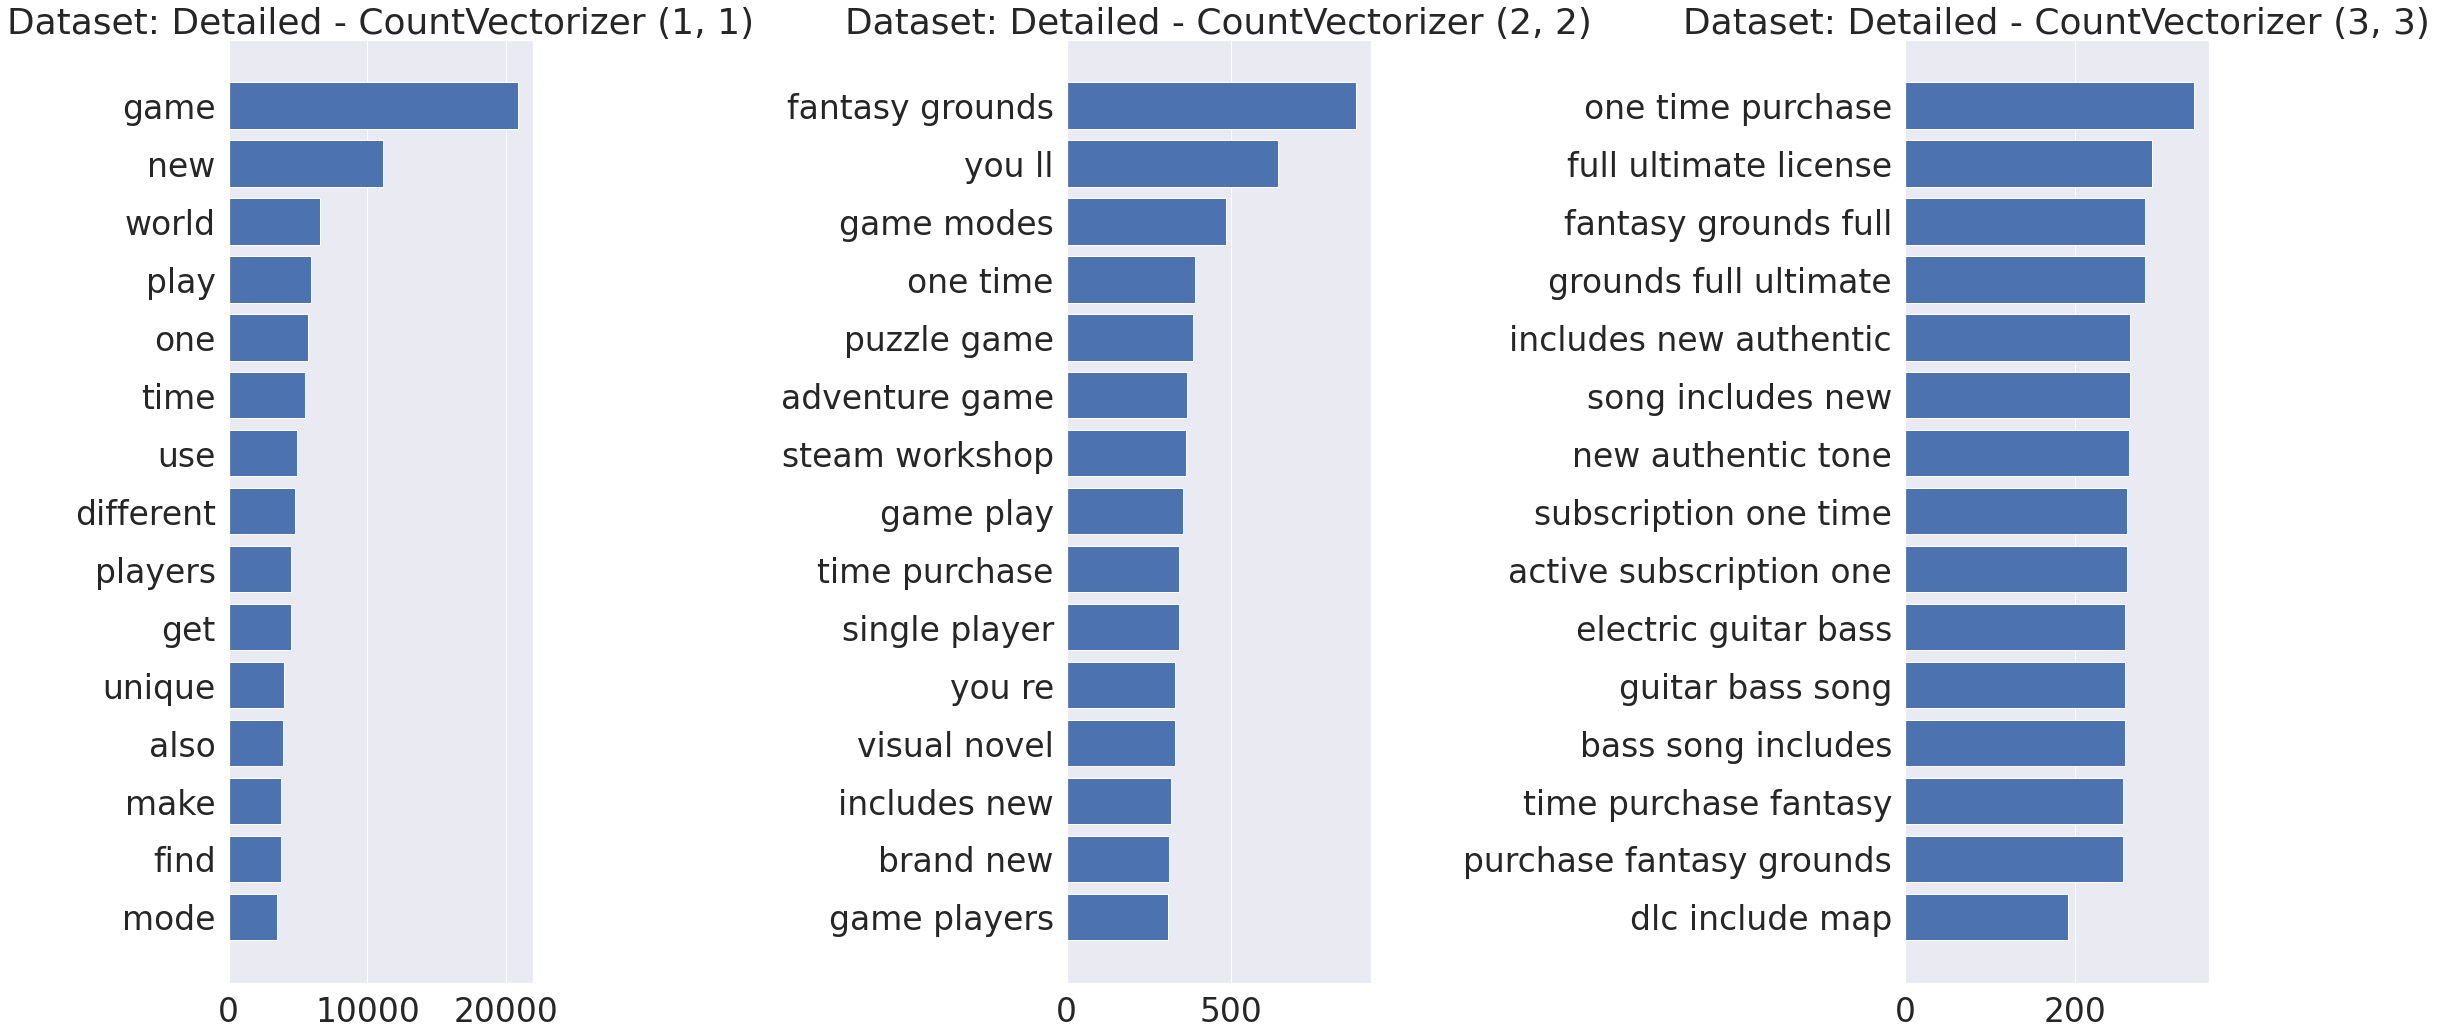

In [46]:
countplots(GameData[GameData["detailed_description.1"].isnull() ==False]["detailed_description.1"],"Detailed",[CountVectorizer],cols=3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


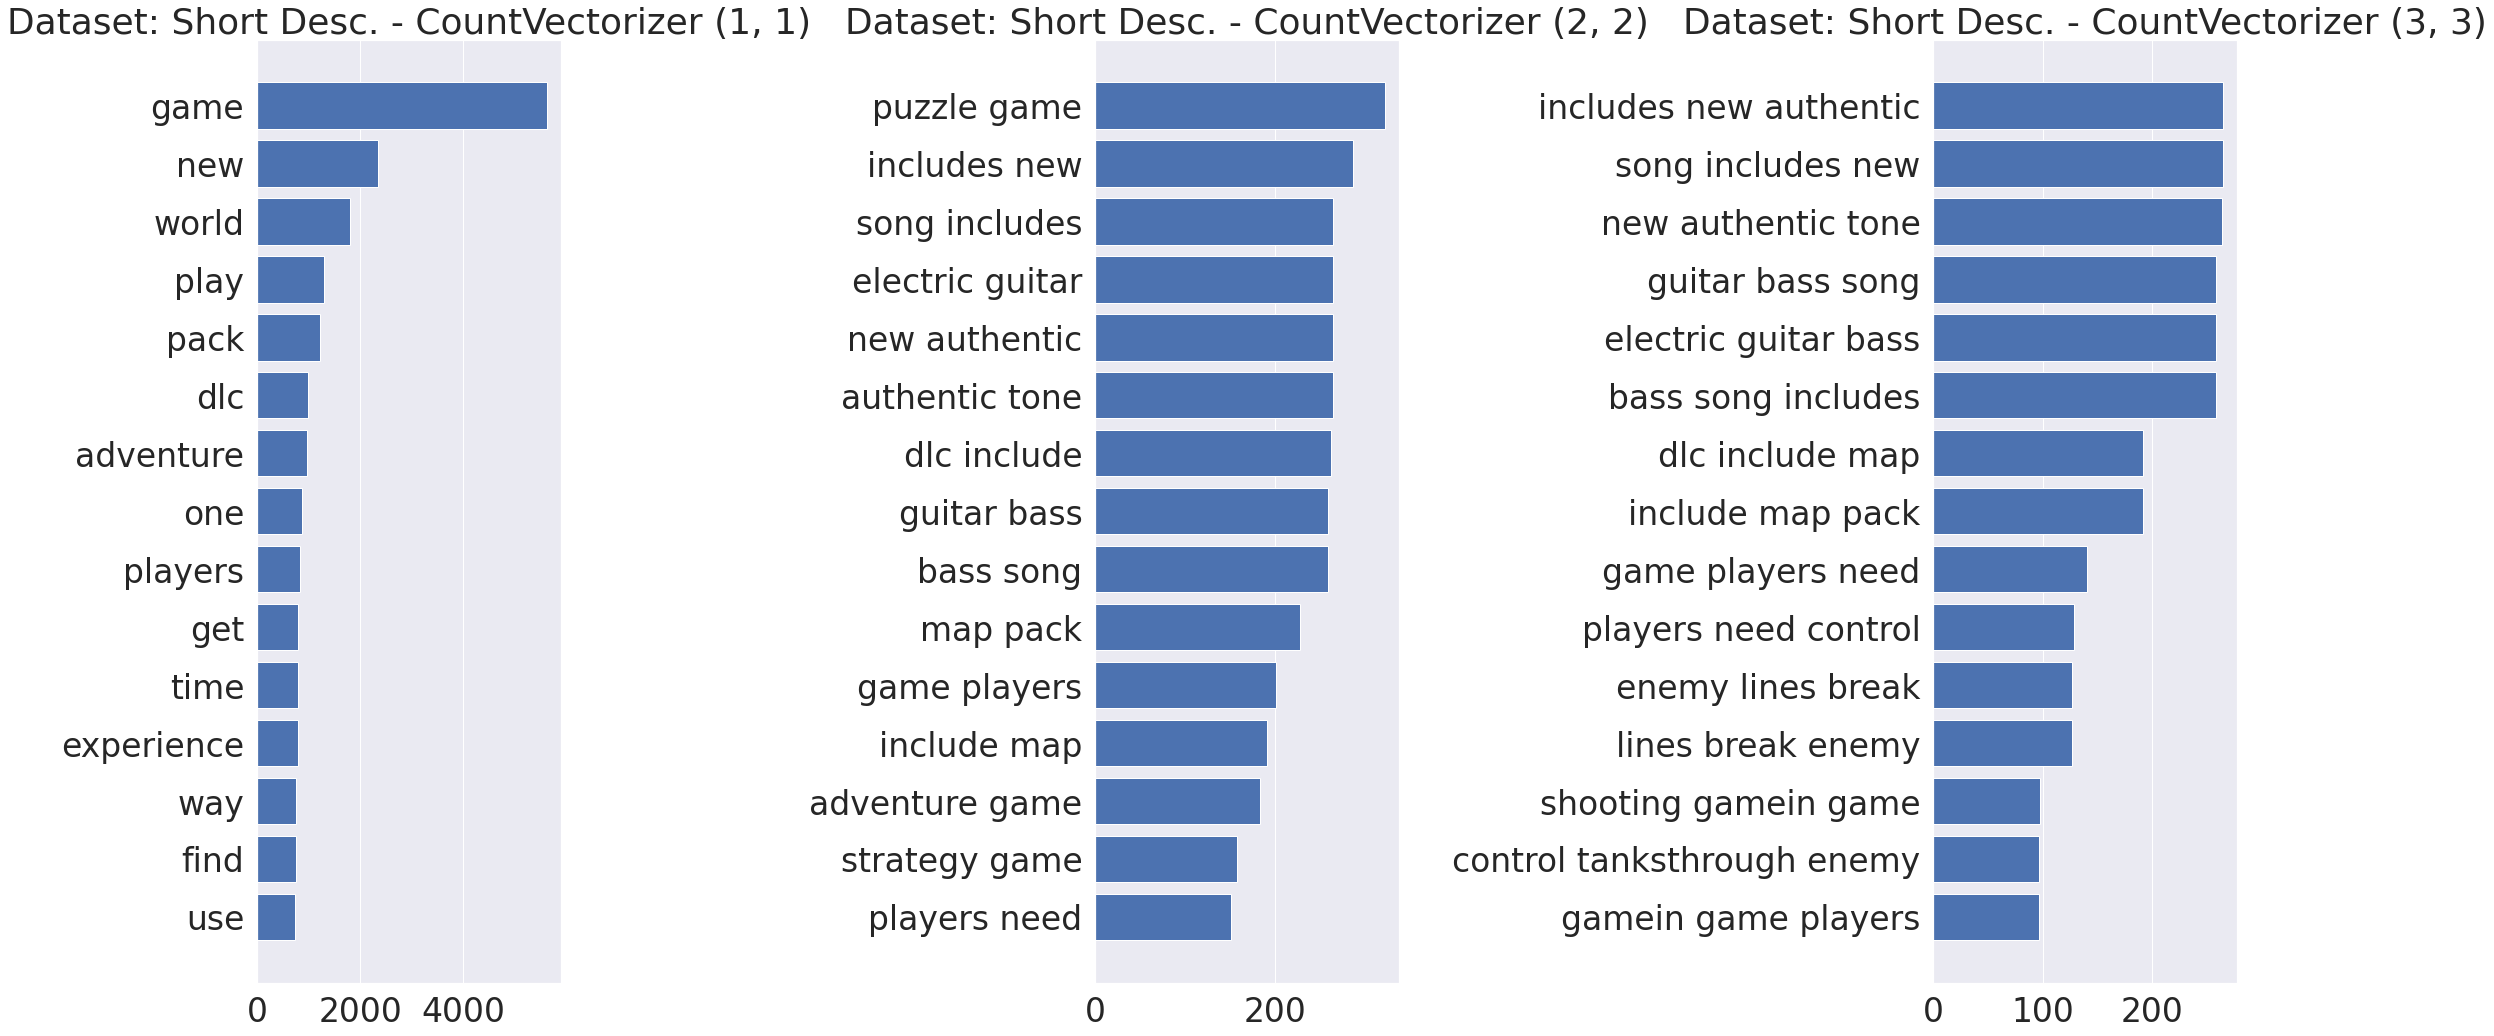

In [47]:
countplots(GameData[GameData["short_description.1"].isnull() ==False]["short_description.1"],"Short Desc.",[CountVectorizer],cols=3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


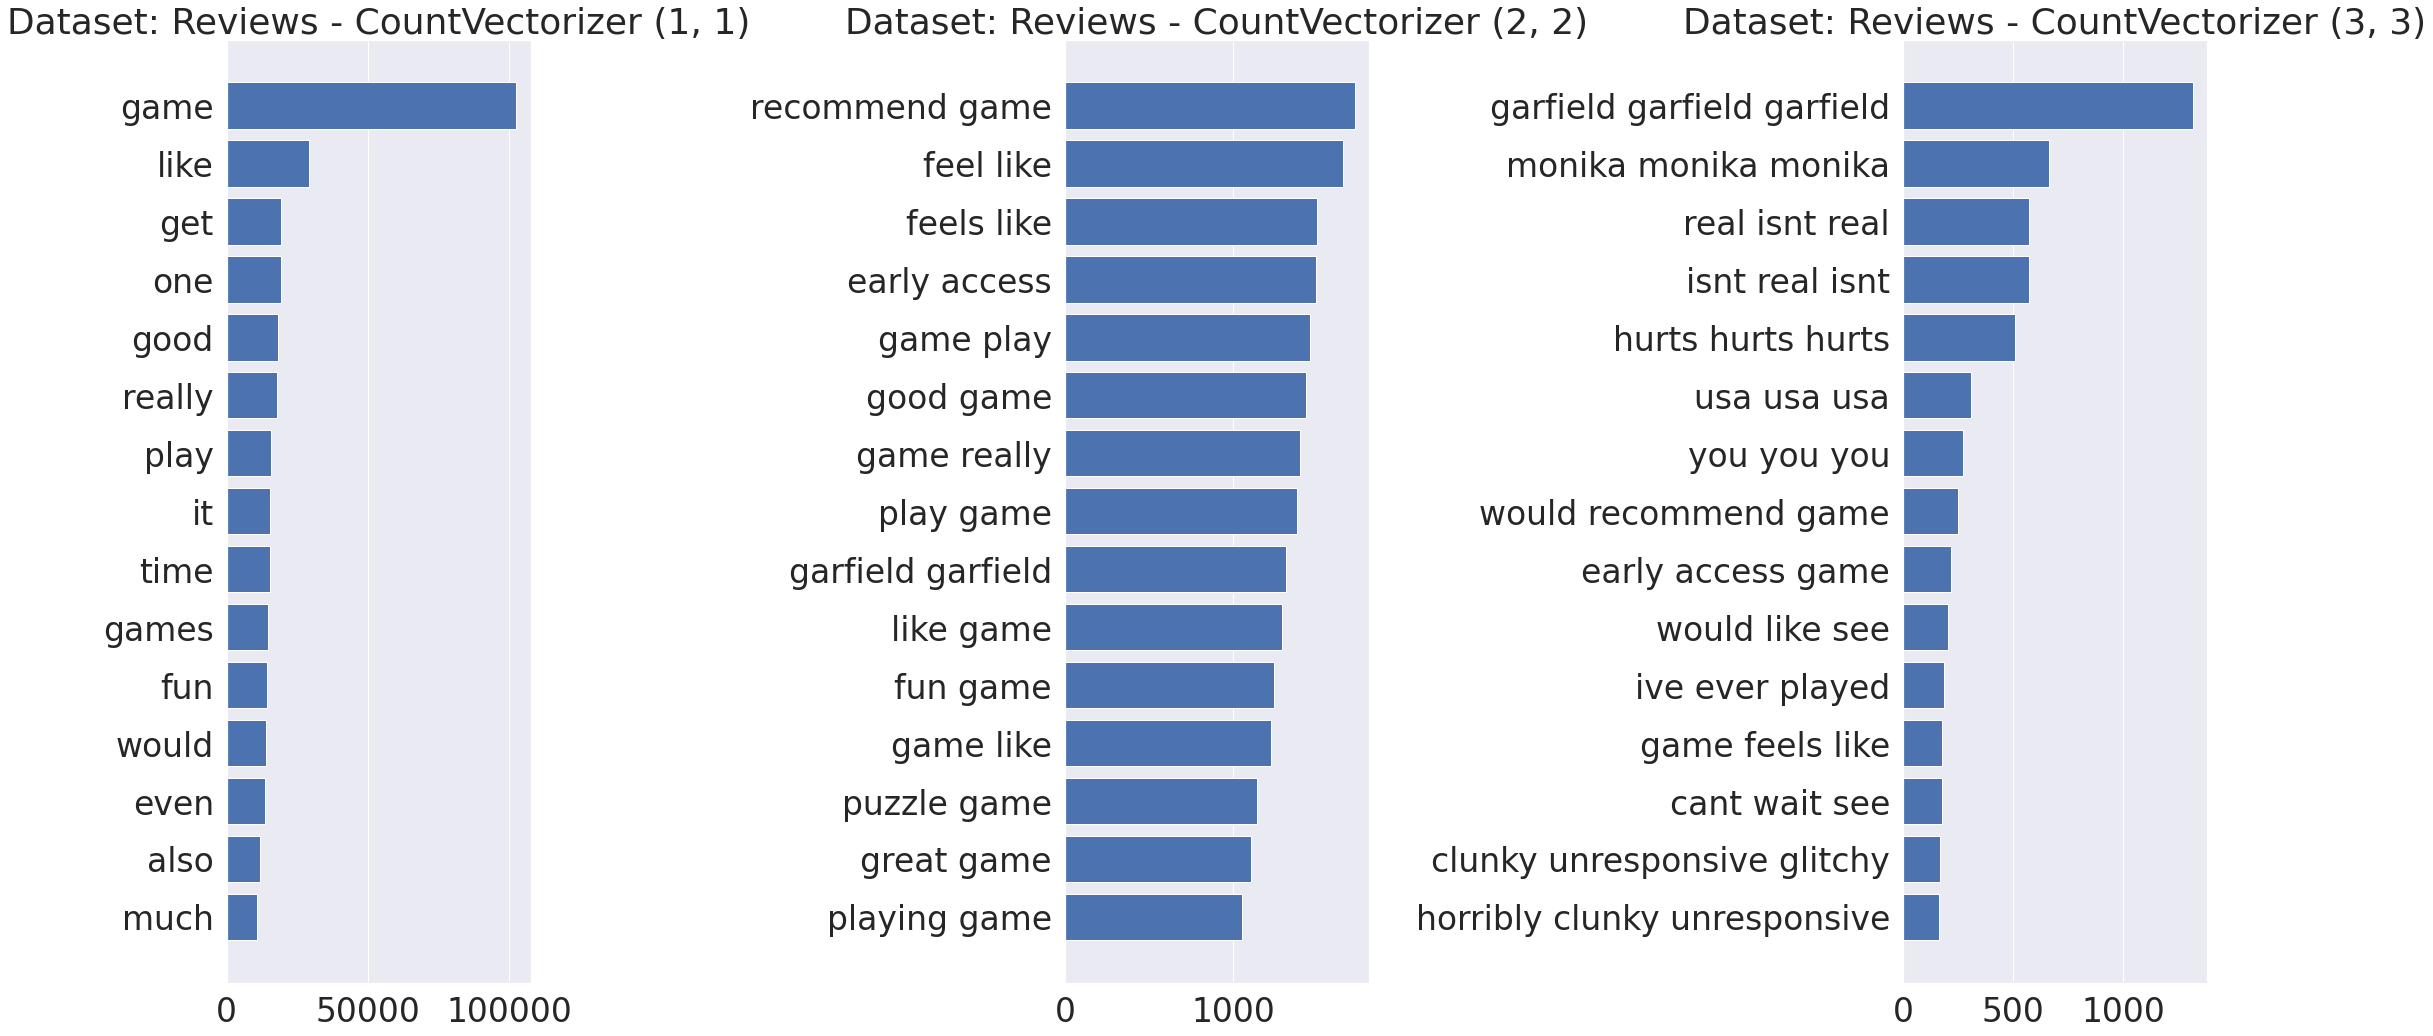

In [48]:
countplots(GameData[GameData["Top Reviews by Upvotes.1"].isnull() ==False]["Top Reviews by Upvotes.1"],"Reviews",[CountVectorizer],cols=3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


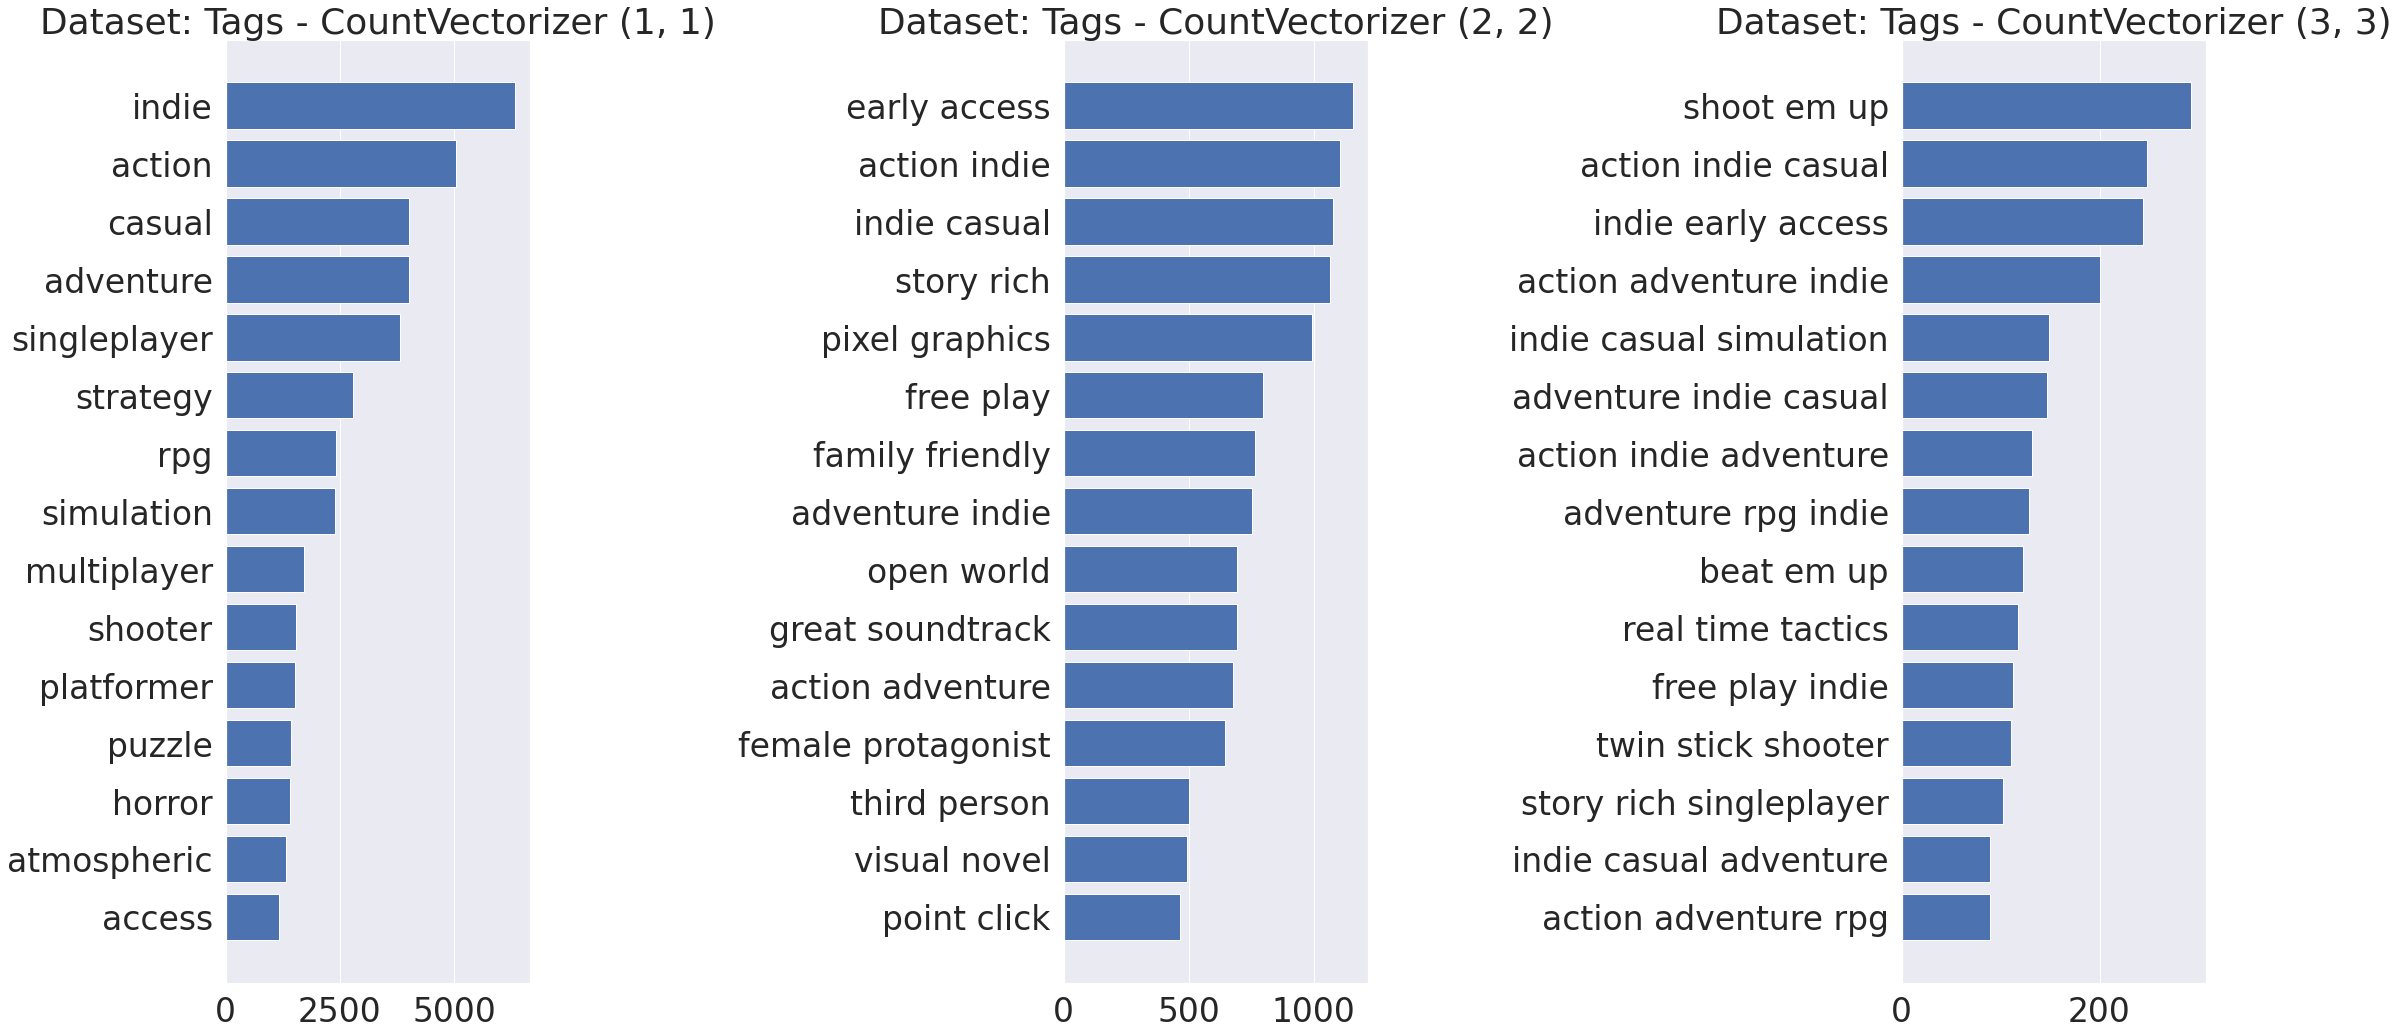

In [49]:
countplots(GameData[GameData["tags.1"].isnull() ==False]['tags.1'],"Tags",[CountVectorizer],cols=3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


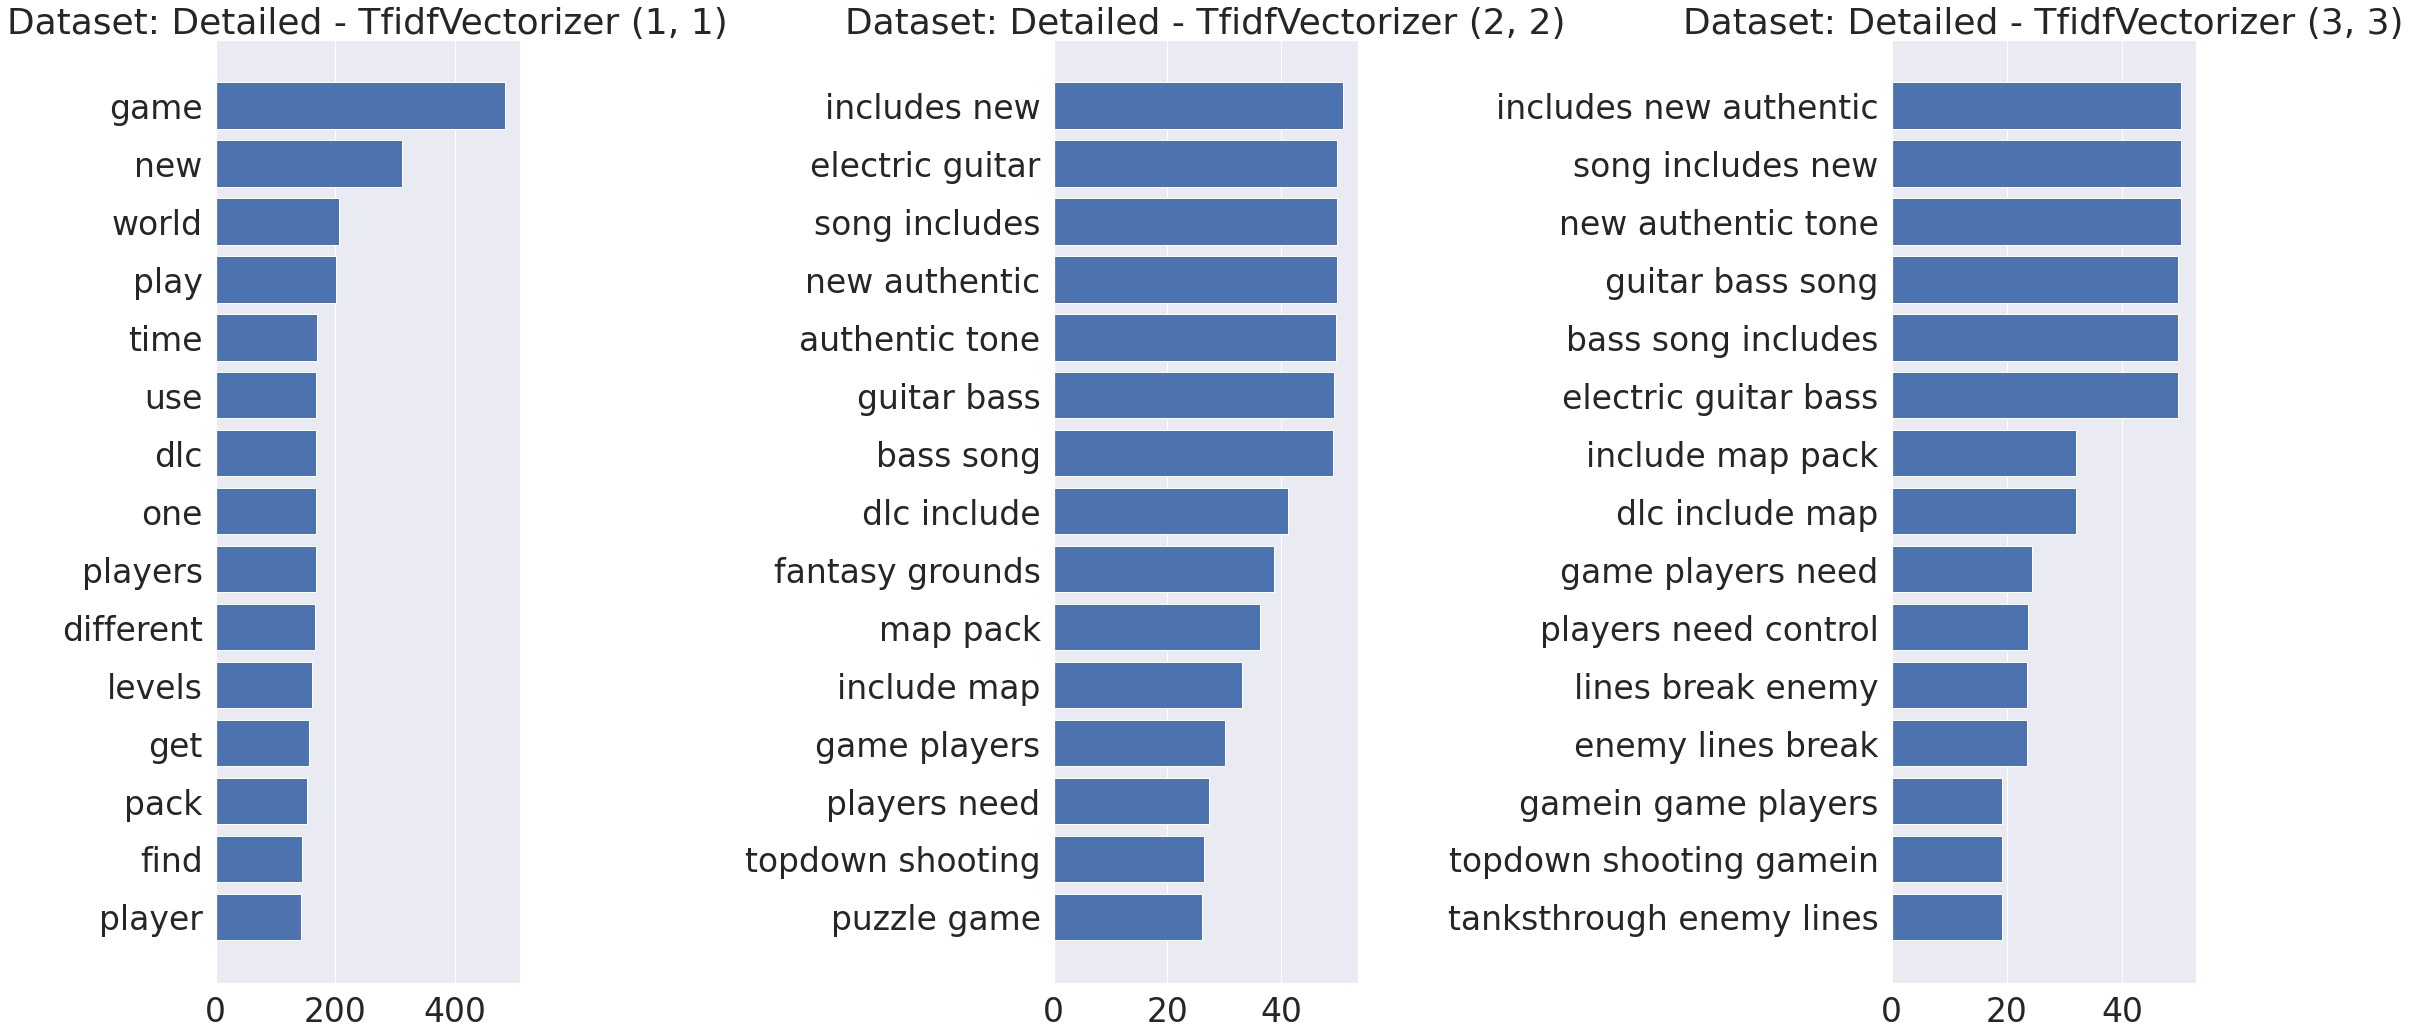

In [50]:
countplots(GameData[GameData["detailed_description.1"].isnull() ==False]["detailed_description.1"],"Detailed",[TfidfVectorizer],cols=3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


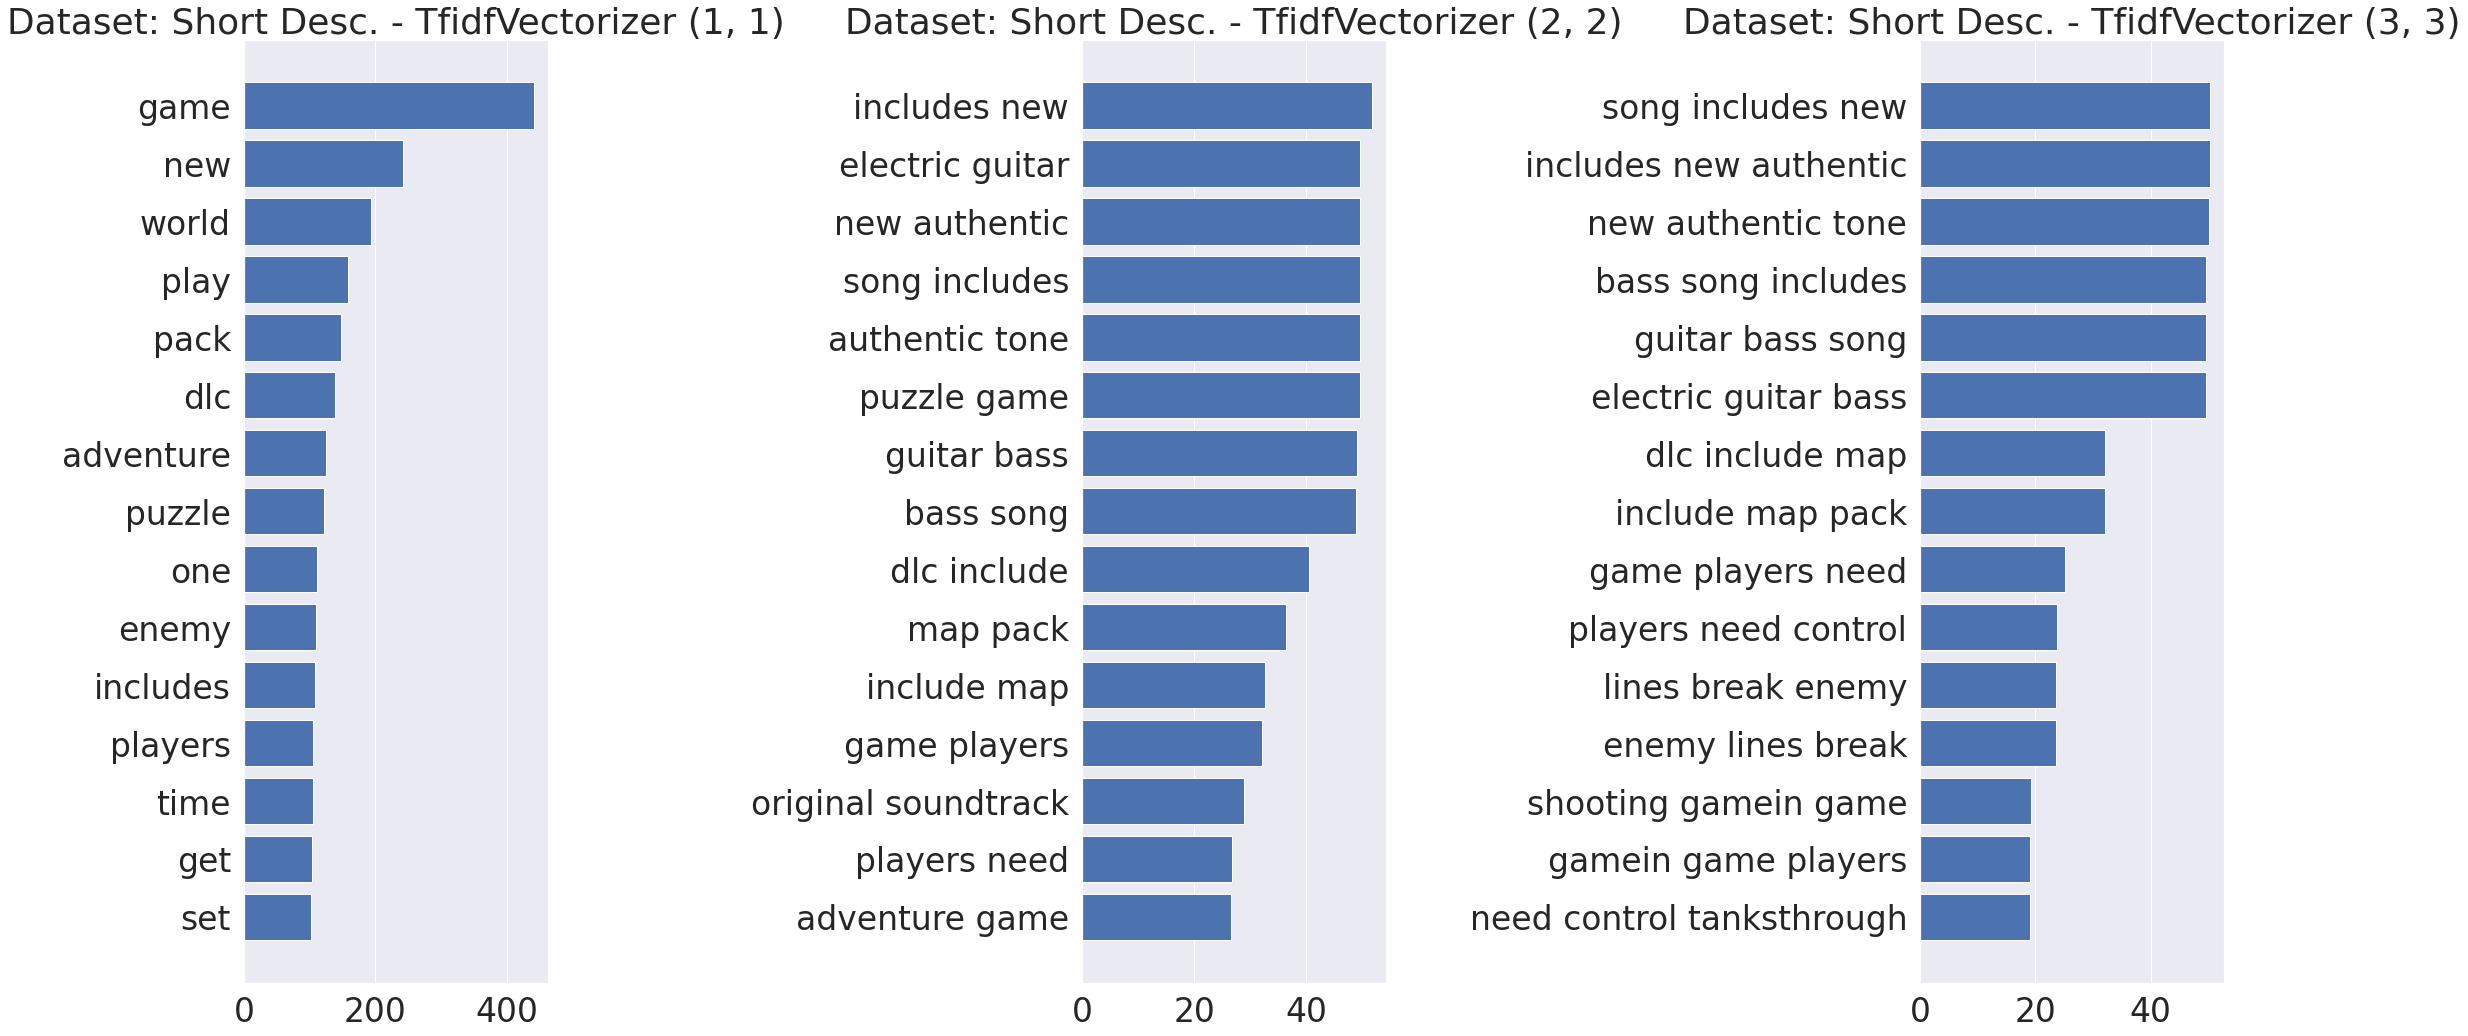

In [51]:
countplots(GameData[GameData["short_description.1"].isnull() ==False]["short_description.1"],"Short Desc.",[TfidfVectorizer],cols=3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


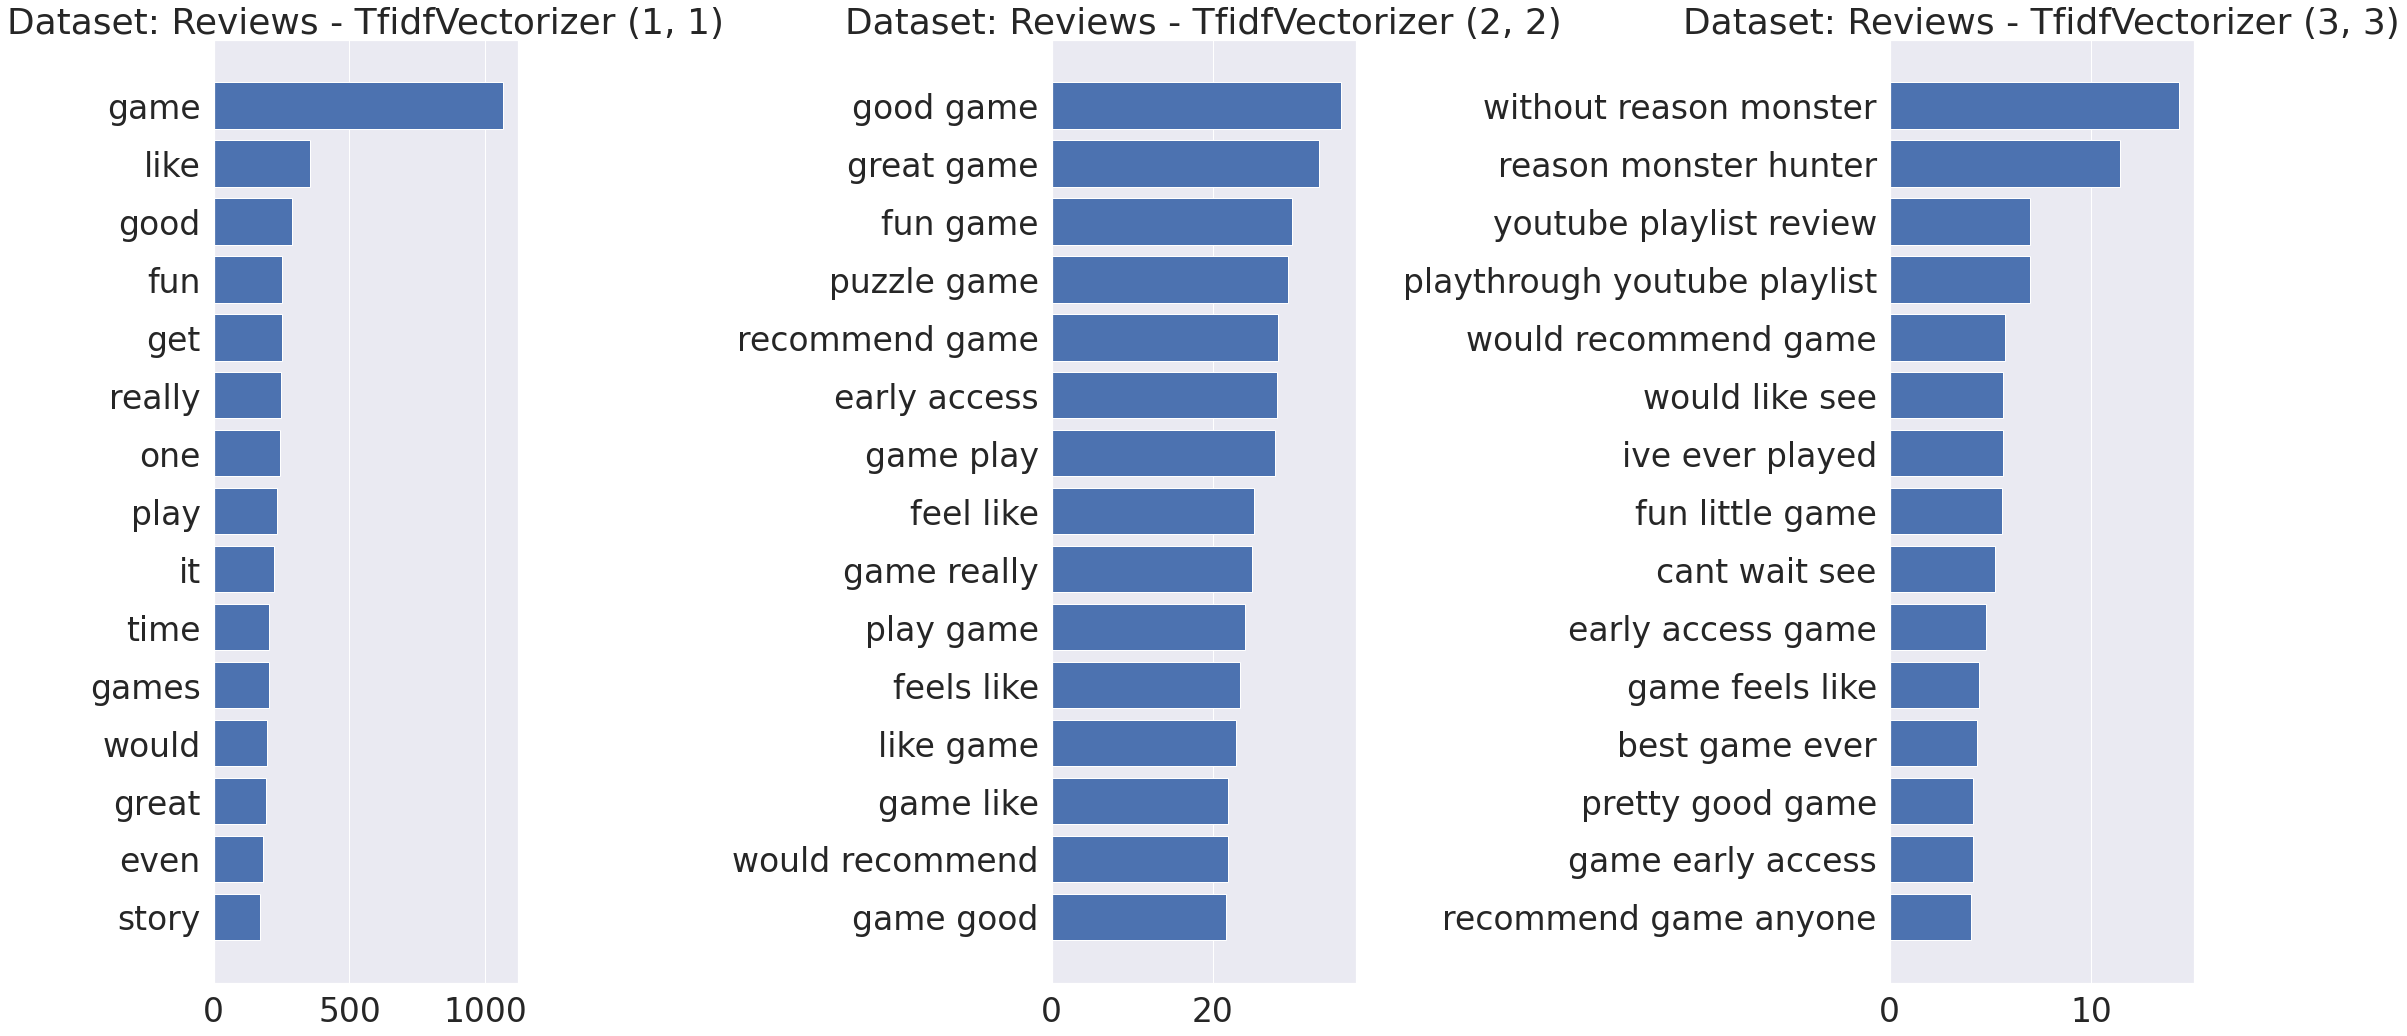

In [52]:
countplots(GameData[GameData["Top Reviews by Upvotes.1"].isnull() ==False]["Top Reviews by Upvotes.1"],"Reviews",[TfidfVectorizer],cols=3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


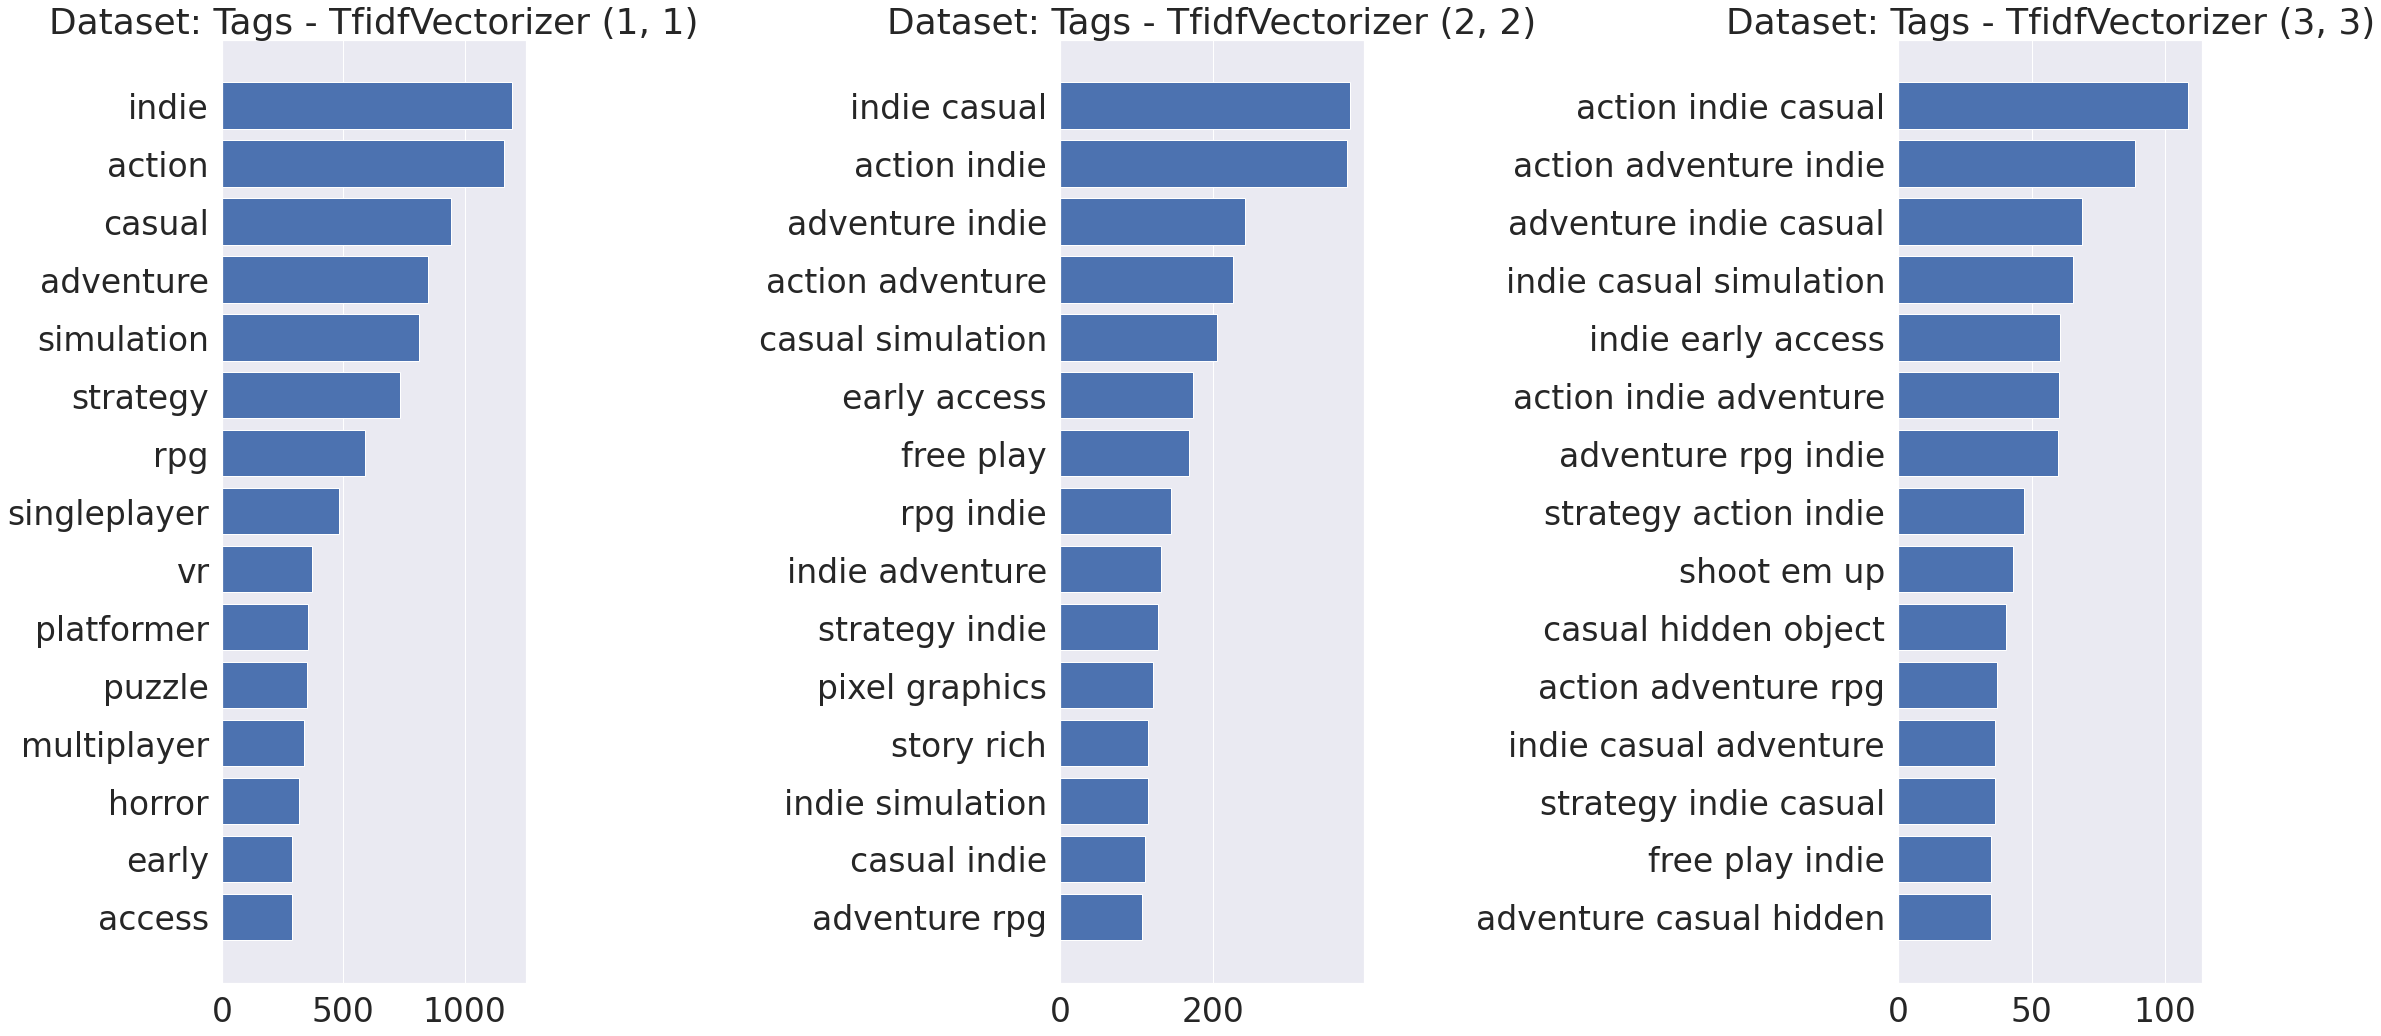

In [53]:
countplots(GameData[GameData["tags.1"].isnull() ==False]['tags.1'],"Tags",[TfidfVectorizer],cols=3)

## Gensim Keyword Extraction

In [54]:
# #Create function to get the top 10 gensim keywords for each column
# def getGensimKeywords(df, col, num_KW=10):
#     '''
#     Input: dataframe, target column, and number of keywords
#     Output, dataframe containing the keywords from that corpus of text
#     '''

#     # KeywordDict = {}
#     # for col in colList:
#     text = ''
#     for textstring in df[col]:
#         text = text + textstring
#     Keywords = keywords(text, words = num_KW, scores = True) #Returns list of keywords and their relevance scores
#         # KeywordDict.update({col:Keywords})
#     return pd.DataFrame(Keywords)

In [55]:
# Columns = ["detailed_description.1","Top Reviews by Upvotes.1", "tags.1"]

# KeywordDict = {}
# for col in Columns:
#     Keywords = getGensimKeywords(GameData[GameData[col].isnull() ==False], col)
#     KeywordDict.update({col:Keywords})
#     print(Keywords)


## Spacy Keyword Extraction

In [56]:
# https://towardsdatascience.com/keyword-extraction-process-in-python-with-natural-language-processing-nlp-d769a9069d5c

def getSpacyKeywords(df, colList, num_KW=10):
    '''
    Input: dataframe, target column, and number of keywords
    Output, dataframe containing the keywords from that corpus of text
    '''
    nlp = spacy.load("en_core_web_sm")
    nlp.add_pipe("textrank") #https://derwen.ai/docs/ptr/start/

    KeywordDict = {}
    for col in colList:
        text = ''
        for textstring in df[col]:
            if str(textstring)!='nan':
                text = text + str(textstring)
        nlp.max_length = 5000000
        doc = nlp(text[0:2000000])
        phrases = []
        for phrase in doc._.phrases:
            phrases.append((phrase.text, phrase.rank))
        Keywords = sorted(list(set(phrases))[0:num_KW],key=itemgetter(1), reverse = True)
        KeywordDict.update({col:Keywords})
        print(col, Keywords)
    print(KeywordDict)
    return pd.DataFrame(KeywordDict)

In [57]:
Columns = ["detailed_description.1","Top Reviews by Upvotes.1", "tags.1"]
Keywords = getSpacyKeywords(GameData, Columns)

detailed_description.1 [('new uniforms', 0.037757708206124195), ('many meeple', 0.019800413756588052), ('whole family', 0.013247325917237715), ('annoying questions', 0.007368297751049861), ('eldora speedway volusia', 0.006404771534946388), ('pretty easygoing sleeping customers', 0.003041432289176349), ('bacon', 0.001997908312816263), ('10 experienceplayers', 0.0007178316441963018), ('142x142', 0.0), ('four', 0.0)]
Top Reviews by Upvotes.1 [('desktop game', 0.09206724545680428), ('4 episodes game', 0.04900482302848745), ('wasok simple first gradually levels', 0.021857573271773352), ('developers platformers', 0.019699502120696044), ('higher speeds', 0.0176459953904897), ('handle cards', 0.014959267934509624), ('fine stages', 0.013615747244993303), ('funky colour boke', 0.006181925267067527), ('stanier class 5 congrats', 0.004911351183747885), ('censoring', 0.0015587061999796903)]
tags.1 [('indie  adventure free play', 0.03773473408444149), ('indie  early access  adventure  fps  fantasy  

In [58]:
Keywords

,detailed_description.1,Top Reviews by Upvotes.1,tags.1
0,"(new uniforms, 0.037757708206124195)","(desktop game, 0.09206724545680428)","(indie adventure free play, 0.03773473408444149)"
1,"(many meeple, 0.019800413756588052)","(4 episodes game, 0.04900482302848745)",(indie early access adventure fps fantasy ...
2,"(whole family, 0.013247325917237715)","(wasok simple first gradually levels, 0.021857...",(realistic cinematic abstract action indie ...
3,"(annoying questions, 0.007368297751049861)","(developers platformers, 0.019699502120696044)",(dark pve procedural generation singleplaye...
4,"(eldora speedway volusia, 0.006404771534946388)","(higher speeds, 0.0176459953904897)",( pixel graphics retro adventure rpg arcad...
5,"(pretty easygoing sleeping customers, 0.003041...","(handle cards, 0.014959267934509624)",( indie adventure dark puzzle singleplayer...
6,"(bacon, 0.001997908312816263)","(fine stages, 0.013615747244993303)","( funny great soundtrack platformer retro, ..."
7,"(10 experienceplayers, 0.0007178316441963018)","(funky colour boke, 0.006181925267067527)","( gore third person, 0.020422586322115088)"
8,"(142x142, 0.0)","(stanier class 5 congrats, 0.004911351183747885)",( flight procedural generation parkour expl...
9,"(four, 0.0)","(censoring, 0.0015587061999796903)","(medieval, 0.00965865699556763)"


## Yake Keyword Extraction

In [86]:
# https://towardsdatascience.com/keyword-extraction-process-in-python-with-natural-language-processing-nlp-d769a9069d5c

def getYakeKeywords(df, colList, num_KW=10, ngram = 3):
    '''
    Input: dataframe, target column, and number of keywords
    Output, dataframe containing the keywords from that corpus of text
    '''
    kw_extractor = yake.KeywordExtractor()
    language = "en"
    max_ngram_size = ngram
    deduplication_threshold = 0.9
    numOfKeywords = num_KW
    custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, top=numOfKeywords, features=None)

    KeywordDict = {}
    for col in colList:
        text = ''
        for textstring in df[col]:
            if str(textstring)!='nan':
                if 'game' in textstring:
                    textstring = textstring.replace('game', '')
                    text = text + str(textstring)
                if 'play' in textstring:
                    textstring = textstring.replace('play', '')
                    text = text + str(textstring)
                if 'version' in textstring:
                    textstring = textstring.replace('version', '')
                    text = text + str(textstring)
                if 'purchase' in textstring:
                    textstring = textstring.replace('purchase', '')
                    text = text + str(textstring)
                else:
                   text = text + str(textstring) 
        Keywords = custom_kw_extractor.extract_keywords(text)
        KeywordDict.update({col:Keywords})
        print(col, Keywords)
    print(KeywordDict)
    return pd.DataFrame.from_dict(KeywordDict)


In [87]:
Columns = ["detailed_description.1","Top Reviews by Upvotes.1", "tags.1"]
Keywords = getYakeKeywords(GameData, Columns)
Keywords

detailed_description.1 [('include map pack', 5.265669686109505e-07), ('dlc include map', 6.652506537003649e-07), ('fantasy grounds full', 7.389540130902042e-07), ('time fantasy grounds', 1.1021332142888907e-06), ('time purchase fantasy', 1.133295960344797e-06), ('grounds full ultimate', 1.3583926923423605e-06), ('feature dlc include', 1.4845481898999055e-06), ('world', 1.619918299039724e-06), ('designed fantasy grounds', 1.8747720216346387e-06), ('object puzzle adventure', 1.9888110700159925e-06)]
Top Reviews by Upvotes.1 [('good good bad', 1.817818772911786e-07), ('good', 3.9861499071645264e-07), ('time', 4.02050134723379e-07), ('pretty good', 4.472992608426721e-07), ('good bad bad', 4.758520817168228e-07), ('good story good', 5.00092689189643e-07), ('lot fun', 5.365019542347832e-07), ('good graphics good', 5.398420736967515e-07), ('play good good', 5.515436065365353e-07), ('good time', 6.408059043241292e-07)]
tags.1 [('action indie casual', 1.1131487983402461e-08), ('action adventure

,detailed_description.1,Top Reviews by Upvotes.1,tags.1
0,"(include map pack, 5.265669686109505e-07)","(good good bad, 1.817818772911786e-07)","(action indie casual, 1.1131487983402461e-08)"
1,"(dlc include map, 6.652506537003649e-07)","(good, 3.9861499071645264e-07)","(action adventure indie, 1.5288960638995835e-08)"
2,"(fantasy grounds full, 7.389540130902042e-07)","(time, 4.02050134723379e-07)","(action indie adventure, 2.121243230017747e-08)"
3,"(time fantasy grounds, 1.1021332142888907e-06)","(pretty good, 4.472992608426721e-07)","(adventure indie casual, 2.4136666733985967e-08)"
4,"(time purchase fantasy, 1.133295960344797e-06)","(good bad bad, 4.758520817168228e-07)","(indie action adventure, 2.4260925564873634e-08)"
5,"(grounds full ultimate, 1.3583926923423605e-06)","(good story good, 5.00092689189643e-07)","(indie casual simulation, 3.056390564713978e-08)"
6,"(feature dlc include, 1.4845481898999055e-06)","(lot fun, 5.365019542347832e-07)","(indie casual adventure, 3.1189588831579266e-08)"
7,"(world, 1.619918299039724e-06)","(good graphics good, 5.398420736967515e-07)","(casual action indie, 3.485913342170771e-08)"
8,"(designed fantasy grounds, 1.8747720216346387e...","(play good good, 5.515436065365353e-07)","(indie casual action, 3.6126738273406174e-08)"
9,"(object puzzle adventure, 1.9888110700159925e-06)","(good time, 6.408059043241292e-07)","(adventure action indie, 4.134259764626426e-08)"


## Pre and During Covid Analyses

In [61]:
#Create Pre and During Covid data sets to use later:
preCOVID = GameData[GameData['Release Year'].isin([2018,2019])]
COVID = GameData[GameData['Release Year'].isin([2021,2022])]

In [62]:
preCOVID.describe()

,Unnamed: 0,required_age,Review Score,appid,positive,negative,price,initialprice,discount,Single-player,Steam Achievements,Steam Workshop,Steam Cloud,Includes level editor,Downloadable Content,Multi-player,Shared/Split Screen,Full controller support,Steam Trading Cards,Remote Play Together,Partial Controller Support,Steam Leaderboards,Captions available,Stats,PvP,Online PvP,Co-op,Online Co-op,MMO,In-App Purchases,Shared/Split Screen PvP,Shared/Split Screen Co-op,Cross-Platform Multiplayer,LAN PvP,LAN Co-op,Valve Anti-Cheat enabled,Remote Play on TV,VR Support,Remote Play on Phone,Remote Play on Tablet,Action,Casual,Indie,Simulation,Strategy,Early Access,Racing,RPG,Adventure,Education,Game Development,Massively Multiplayer,Design & Illustration,Web Publishing,Violent,Gore,Sports,Animation & Modeling,Audio Production,Software Training,Utilities,Video Production,Photo Editing,Release Year
count,4190.000000,4190.000000,4189.000000,4.189000e+03,4189.000000,4189.000000,4170.000000,4170.000000,4170.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.00000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000
mean,9315.749881,0.327208,1.738601,9.241249e+05,526.169014,101.912867,694.321823,715.430216,2.476739,0.886396,0.512172,0.046778,0.292363,0.034368,0.369451,0.265394,0.125537,0.239857,0.186396,0.059427,0.169212,0.137709,0.014558,0.051790,0.204535,0.168258,0.154177,0.08043,0.018854,0.070644,0.083532,0.042959,0.062291,0.004296,0.004296,0.002148,0.025776,0.004535,0.007637,0.010740,0.389260,0.370406,0.656086,0.230310,0.202864,0.069212,0.032220,0.192601,0.308353,0.003580,0.003103,0.035322,0.019570,0.020525,0.012649,0.005967,0.053699,0.003580,0.003103,0.001432,0.010501,0.002148,0.000239,2018.494511
std,5362.243314,2.339240,2.914033,1.722672e+05,6764.183416,1601.211690,999.204517,1010.749327,11.695303,0.317367,0.499911,0.211188,0.454902,0.182193,0.482714,0.441595,0.331366,0.427047,0.389473,0.236451,0.374984,0.344635,0.119791,0.221629,0.403409,0.374140,0.361161,0.27199,0.136027,0.256260,0.276718,0.202790,0.241712,0.065410,0.065410,0.046302,0.158484,0.067195,0.087067,0.103088,0.487641,0.482971,0.475070,0.421082,0.402180,0.253845,0.176604,0.394390,0.461868,0.059733,0.055621,0.184615,0.138535,0.141805,0.111768,0.077022,0.225450,0.059733,0.055621,0.037819,0.101948,0.046302,0.015449,0.500030
min,20.000000,0.000000,0.000000,2.211000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2018.000000
25%,4565.000000,0.000000,0.000000,8.208700e+05,0.000000,0.000000,99.000000,99.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [63]:
COVID.describe()

,Unnamed: 0,required_age,Review Score,appid,positive,negative,price,initialprice,discount,Single-player,Steam Achievements,Steam Workshop,Steam Cloud,Includes level editor,Downloadable Content,Multi-player,Shared/Split Screen,Full controller support,Steam Trading Cards,Remote Play Together,Partial Controller Support,Steam Leaderboards,Captions available,Stats,PvP,Online PvP,Co-op,Online Co-op,MMO,In-App Purchases,Shared/Split Screen PvP,Shared/Split Screen Co-op,Cross-Platform Multiplayer,LAN PvP,LAN Co-op,Valve Anti-Cheat enabled,Remote Play on TV,VR Support,Remote Play on Phone,Remote Play on Tablet,Action,Casual,Indie,Simulation,Strategy,Early Access,Racing,RPG,Adventure,Education,Game Development,Massively Multiplayer,Design & Illustration,Web Publishing,Violent,Gore,Sports,Animation & Modeling,Audio Production,Software Training,Utilities,Video Production,Photo Editing,Release Year
count,3560.000000,3560.000000,3560.000000,3.560000e+03,3560.000000,3560.000000,3227.000000,3227.000000,3227.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.0,3560.0,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000
mean,9158.814045,0.123315,1.405899,1.586692e+06,200.404494,33.262921,823.074992,847.228385,3.309575,0.906461,0.448876,0.045225,0.248315,0.028090,0.350843,0.222472,0.078371,0.245225,0.079775,0.050000,0.156742,0.103933,0.010955,0.033427,0.141573,0.119663,0.137360,0.105899,0.014888,0.041292,0.042697,0.048034,0.044101,0.012640,0.022472,0.001966,0.021629,0.003652,0.009831,0.015449,0.430056,0.438764,0.650281,0.200843,0.202247,0.099719,0.041854,0.203933,0.319101,0.003090,0.003933,0.026966,0.023315,0.021067,0.0,0.0,0.040169,0.006461,0.004775,0.002809,0.011236,0.004213,0.003371,2021.125281
std,5331.638881,1.447485,2.791453,2.302631e+05,2330.006212,417.269203,1161.759689,1184.907004,11.893589,0.291228,0.497449,0.207826,0.432096,0.165253,0.477301,0.415965,0.268792,0.430281,0.270983,0.217976,0.363608,0.305216,0.104106,0.179774,0.348661,0.324613,0.344275,0.307751,0.121120,0.198993,0.202201,0.213868,0.205349,0.111733,0.148233,0.044305,0.145490,0.060327,0.098679,0.123349,0.495153,0.496306,0.476948,0.400687,0.401732,0.299667,0.200283,0.402976,0.466194,0.055509,0.062596,0.162008,0.150922,0.143629,0.0,0.0,0.196382,0.080130,0.068948,0.052933,0.105417,0.064784,0.057969,0.331084
min,1.000000,0.000000,0.000000,2.404300e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2021.000000
25%,4416.750000,0.000000,0.000000,1.515192e+06,0.000000,0.000000,119.000000,199.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2021.00000

AttributeError: ignored

<Figure size 1440x720 with 0 Axes>

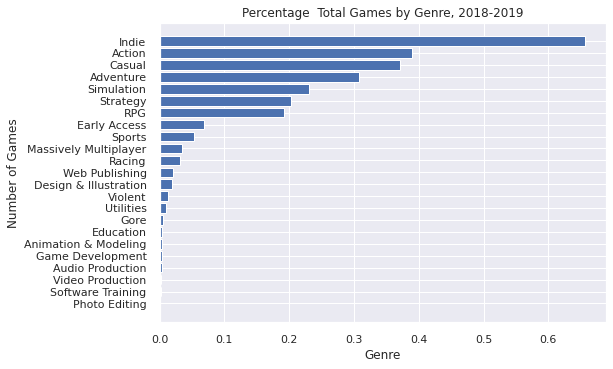

In [64]:
#Bar graph of Genre Frequencies

Genres = ['Action', 'Casual',
       'Indie', 'Simulation', 'Strategy', 'Early Access', 'Racing', 'RPG',
       'Adventure', 'Education', 'Game Development', 'Massively Multiplayer',
       'Design & Illustration', 'Web Publishing', 'Violent',
       'Gore', 'Sports', 'Animation & Modeling', 'Audio Production',
       'Software Training', 'Utilities', 'Video Production', 'Photo Editing',
       ]
sns.set(font_scale = 1)  
Freq = {}
for item in Genres:
    Freq.update({item:preCOVID[item].sum()})
    
Gen_Freq = pd.DataFrame.from_dict(Freq, orient = 'index').reset_index()
Gen_Freq = Gen_Freq.rename(columns = {'index': 'Genre', 0: 'Game Count'})
Gen_Freq = Gen_Freq.sort_values('Game Count')

fig = plt.figure(figsize = (20, 10))
Genre = Gen_Freq['Genre']
Counts = Gen_Freq['Game Count']
# creating the Horizontal bar plot

fig, ax = plt.subplots()
y_pos = np.arange(len(Genre))
 
hbars = ax.barh(y_pos, Counts/4190, align='center')
plt.yticks(y_pos, Genre)
plt.xlabel("Genre")
plt.ylabel("Number of Games")
plt.title("Percentage  Total Games by Genre, 2018-2019")
# Label with specially formatted floats
ax.bar_label(hbars)

plt.savefig("GamesbyGenre_preCOVID.png", bbox_inches="tight")

AttributeError: ignored

<Figure size 1440x720 with 0 Axes>

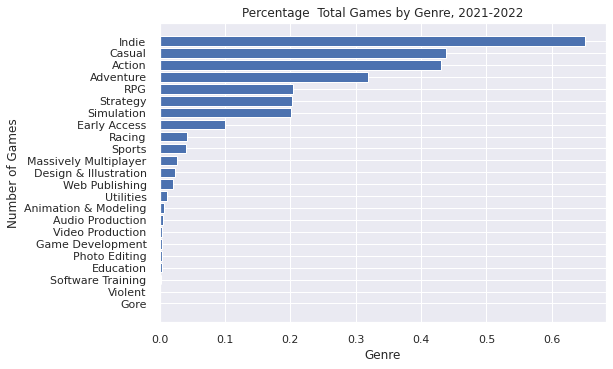

In [65]:
Freq = {}
for item in Genres:
    Freq.update({item:COVID[item].sum()})
    
Gen_Freq = pd.DataFrame.from_dict(Freq, orient = 'index').reset_index()
Gen_Freq = Gen_Freq.rename(columns = {'index': 'Genre', 0: 'Game Count'})
Gen_Freq = Gen_Freq.sort_values('Game Count')

fig = plt.figure(figsize = (20, 10))
Genre = Gen_Freq['Genre']
Counts = Gen_Freq['Game Count']
# creating the Horizontal bar plot

fig, ax = plt.subplots()
y_pos = np.arange(len(Genre))
 
hbars = ax.barh(y_pos, Counts/3560, align='center')
plt.yticks(y_pos, Genre)
plt.xlabel("Genre")
plt.ylabel("Number of Games")
plt.title("Percentage  Total Games by Genre, 2021-2022")
# Label with specially formatted floats
ax.bar_label(hbars)

plt.savefig("GamesbyGenre_COVID.png", bbox_inches="tight")

In [ ]:
Categories = ['Single-player', 'Steam Achievements', 'Steam Workshop',
       'Steam Cloud', 'Includes level editor', 'Downloadable Content',
       'Multi-player', 'Shared/Split Screen', 'Full controller support',
       'Steam Trading Cards', 'Remote Play Together',
       'Partial Controller Support', 'Steam Leaderboards',
       'Captions available', 'Stats', 'PvP', 'Online PvP', 'Co-op',
       'Online Co-op', 'MMO', 'In-App Purchases', 'Shared/Split Screen PvP',
       'Shared/Split Screen Co-op', 'Cross-Platform Multiplayer', 'LAN PvP',
       'LAN Co-op', 'Valve Anti-Cheat enabled', 'Remote Play on TV',
       'VR Support', 'Remote Play on Phone', 'Remote Play on Tablet']

Freq = {}
for cat in Categories:
    Freq.update({cat:preCOVID[cat].sum()})
    
Cat_Freq = pd.DataFrame.from_dict(Freq, orient = 'index').reset_index()
Cat_Freq = Cat_Freq.rename(columns = {'index': 'Category', 0: 'Game Count'})
Cat_Freq = Cat_Freq.sort_values('Game Count')

fig = plt.figure(figsize = (20, 10))
Category = Cat_Freq['Category']
Counts = Cat_Freq['Game Count']
# creating the Horizontal bar plot

fig, ax = plt.subplots()
y_pos = np.arange(len(Category))
 
hbars = ax.barh(y_pos, Counts/4190, align='center')
plt.yticks(y_pos, Category)
plt.xlabel("Category")
plt.ylabel("Number of Games")
plt.title("Number of Games by Category, 2018-2019")
# Label with specially formatted floats
ax.bar_label(hbars)

plt.savefig("GamesbyCategory_preCOVID.png", bbox_inches="tight")

In [ ]:
Freq = {}
for cat in Categories:
    Freq.update({cat:COVID[cat].sum()})
    
Cat_Freq = pd.DataFrame.from_dict(Freq, orient = 'index').reset_index()
Cat_Freq = Cat_Freq.rename(columns = {'index': 'Category', 0: 'Game Count'})
Cat_Freq = Cat_Freq.sort_values('Game Count')

fig = plt.figure(figsize = (20, 10))
Category = Cat_Freq['Category']
Counts = Cat_Freq['Game Count']
# creating the Horizontal bar plot

fig, ax = plt.subplots()
y_pos = np.arange(len(Category))
 
hbars = ax.barh(y_pos, Counts/3560, align='center')
plt.yticks(y_pos, Category)
plt.xlabel("Category")
plt.ylabel("Number of Games")
plt.title("Number of Games by Category, 2021-2022")
# Label with specially formatted floats
ax.bar_label(hbars)

plt.savefig("GamesbyCategory_COVID.png", bbox_inches="tight")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


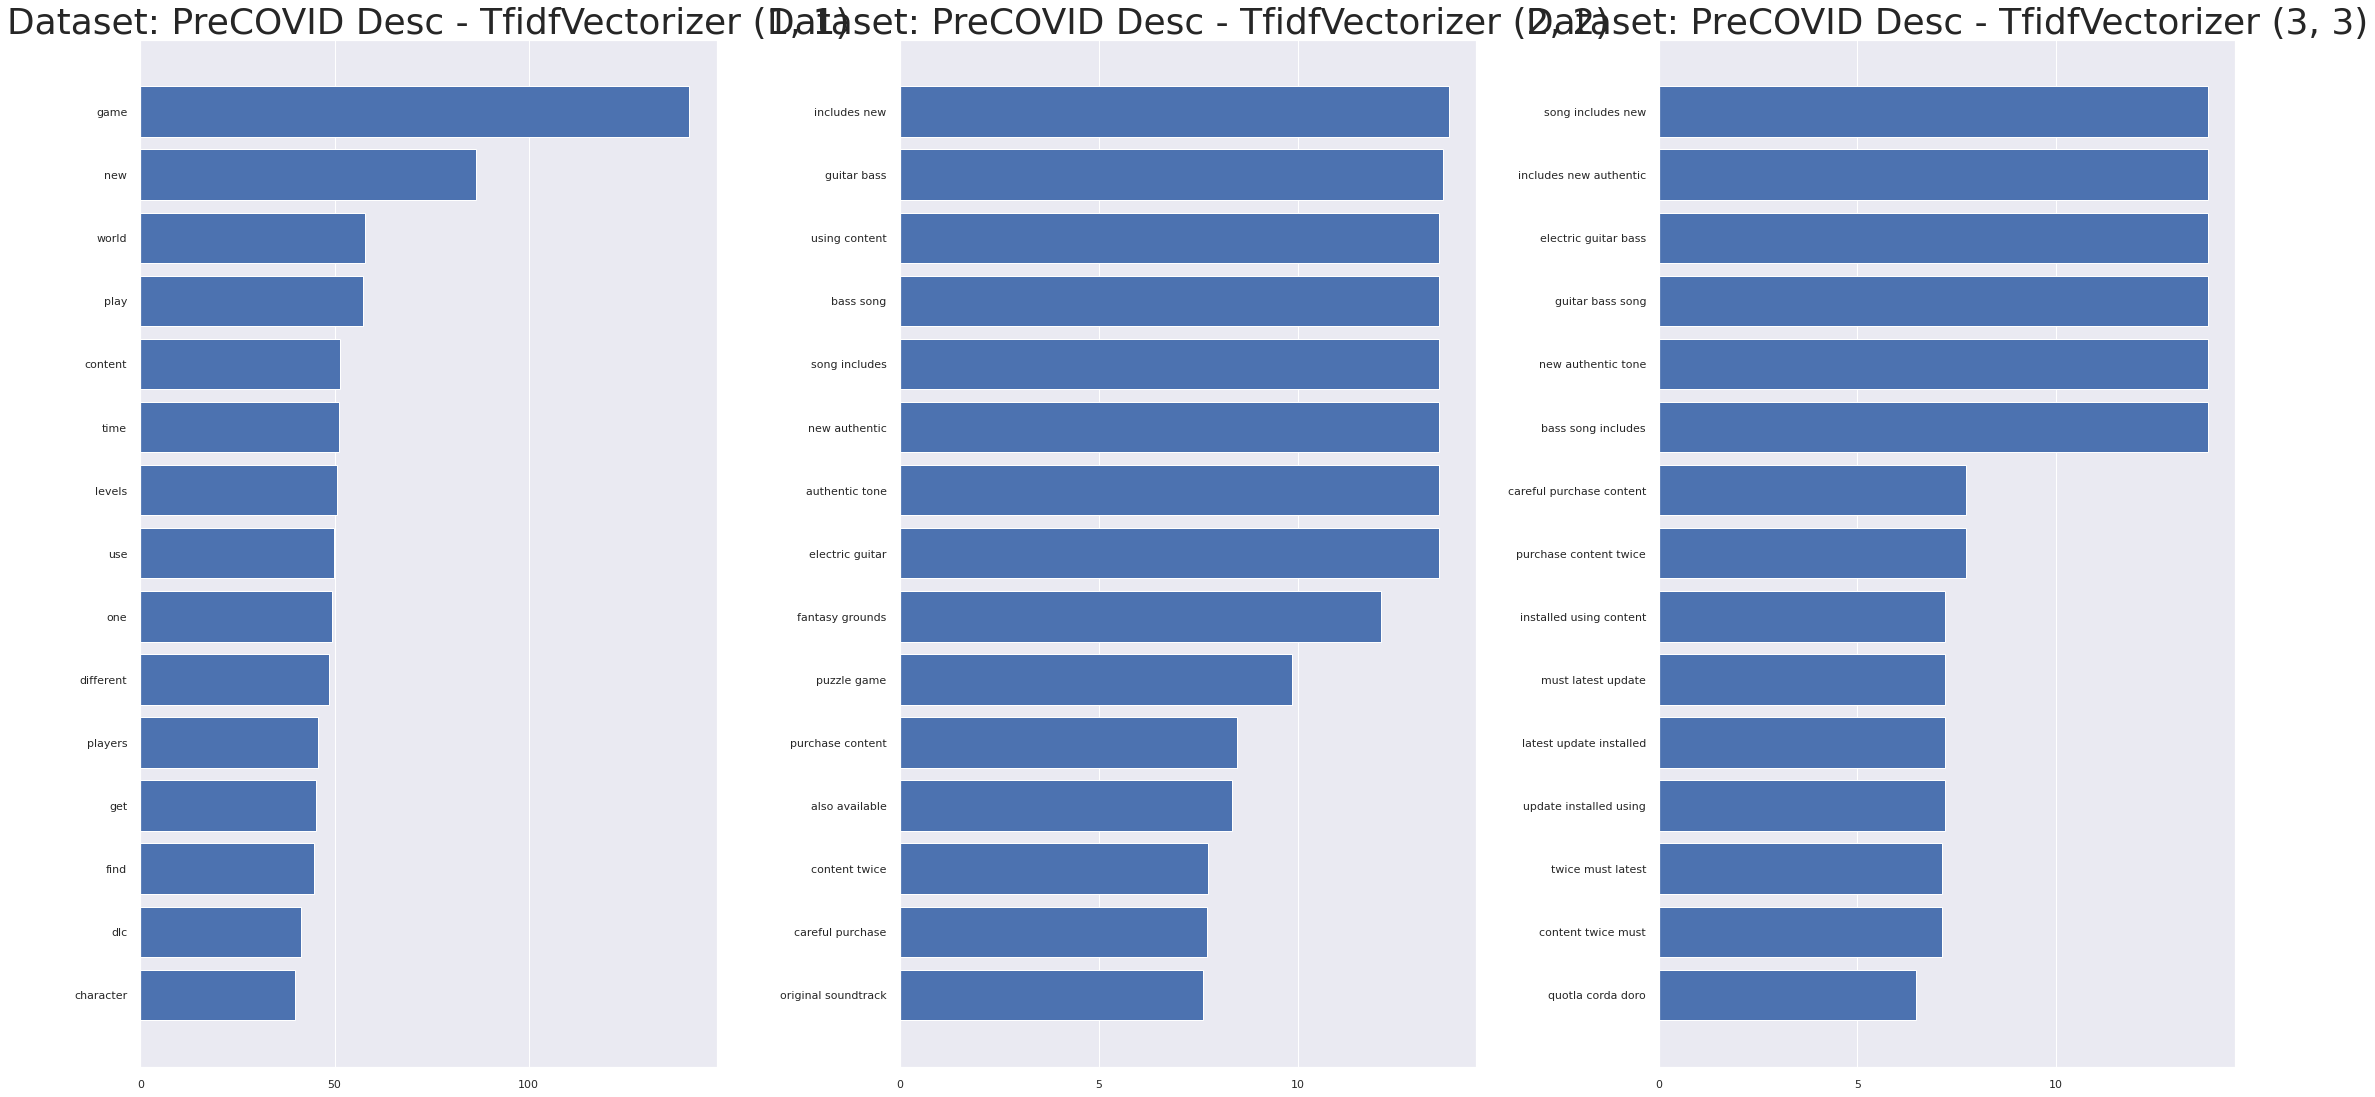

In [66]:
countplots(preCOVID[preCOVID["detailed_description.1"].isnull() ==False]["detailed_description.1"],"PreCOVID Desc",[TfidfVectorizer],cols=3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


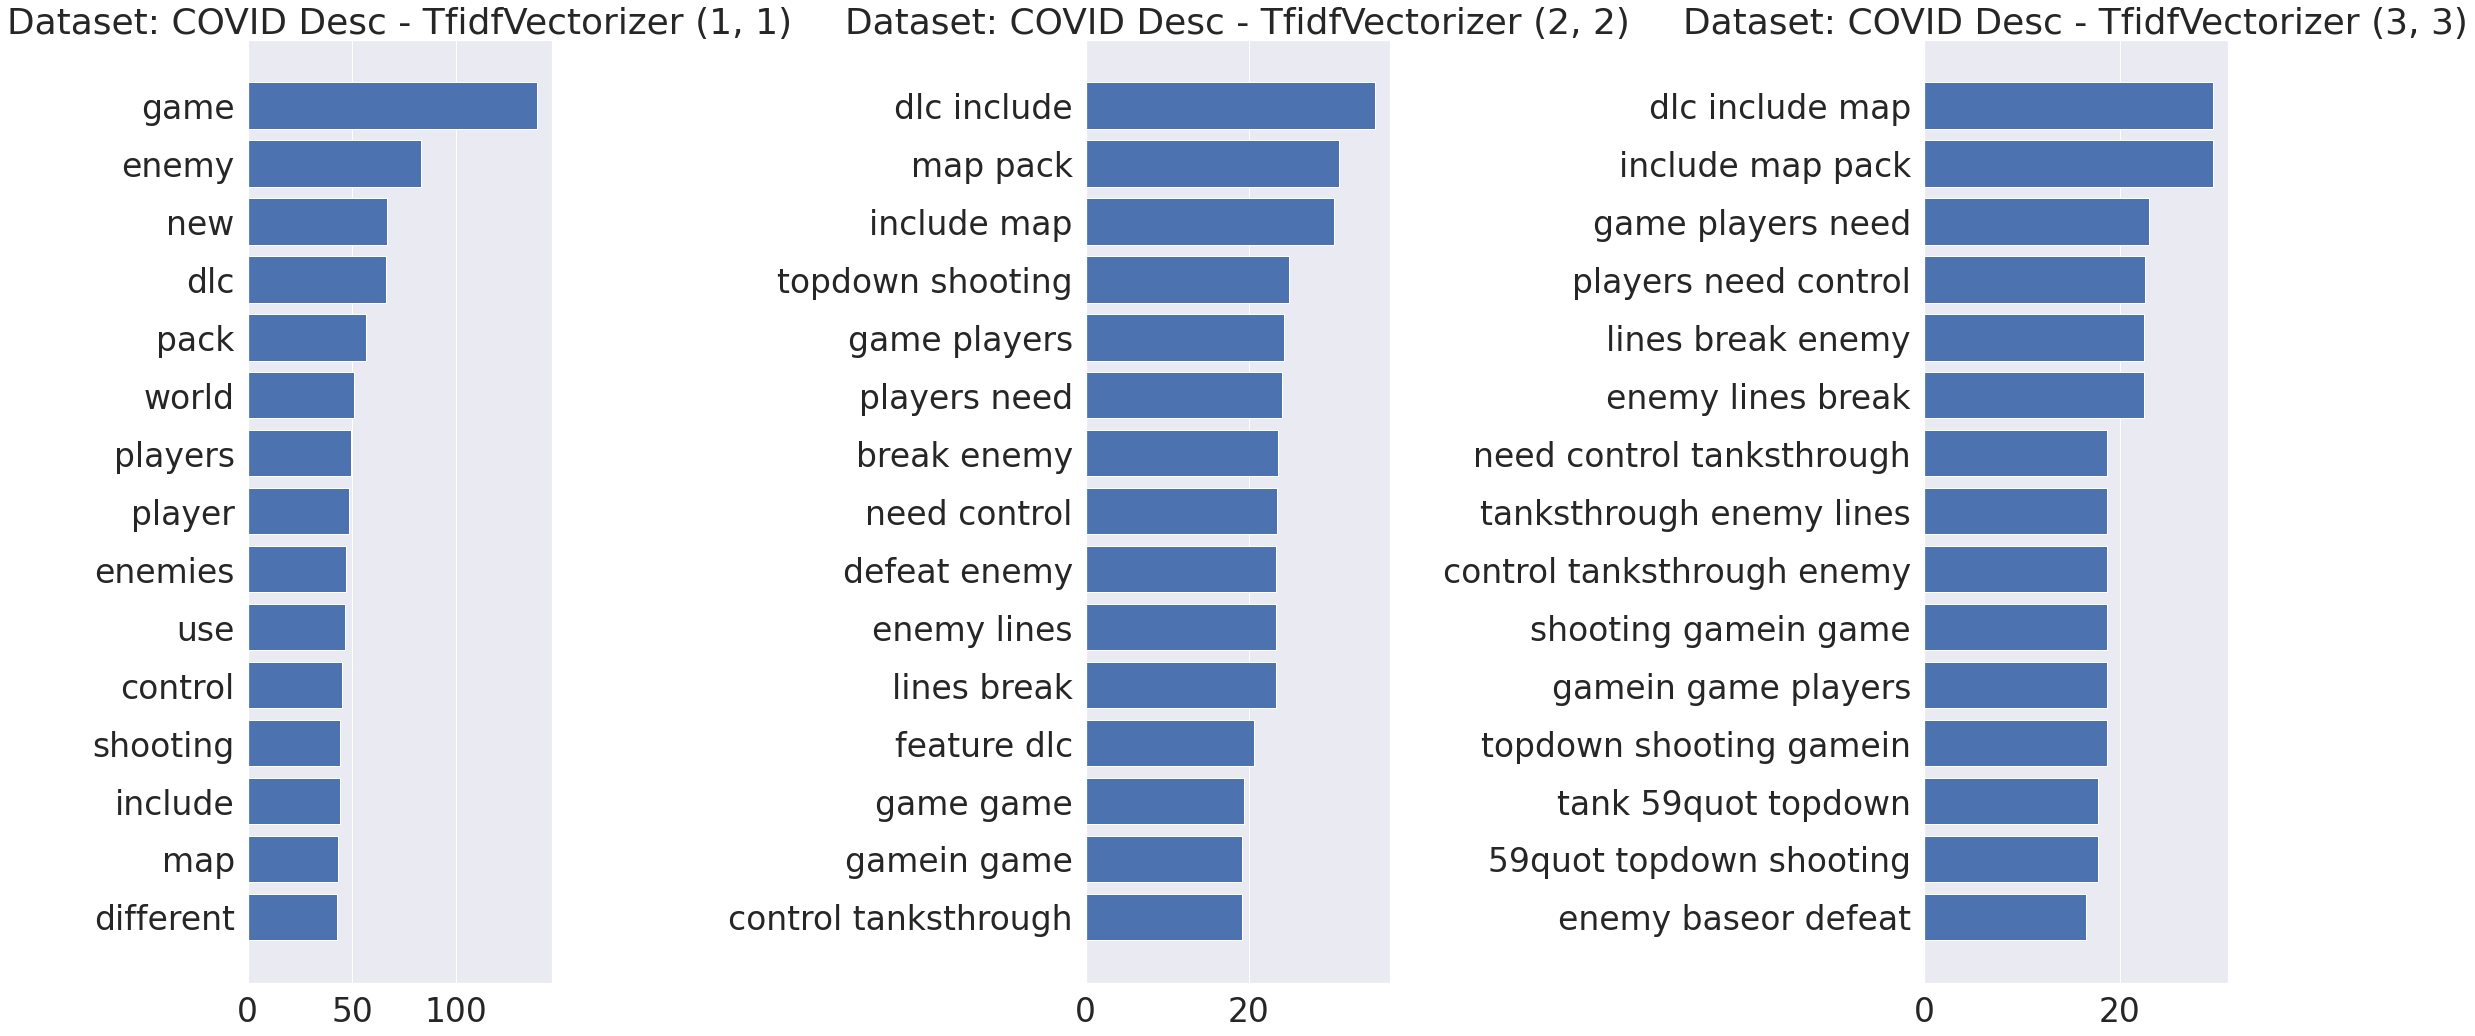

In [67]:
countplots(COVID[COVID["detailed_description.1"].isnull() ==False]["detailed_description.1"],"COVID Desc",[TfidfVectorizer],cols=3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


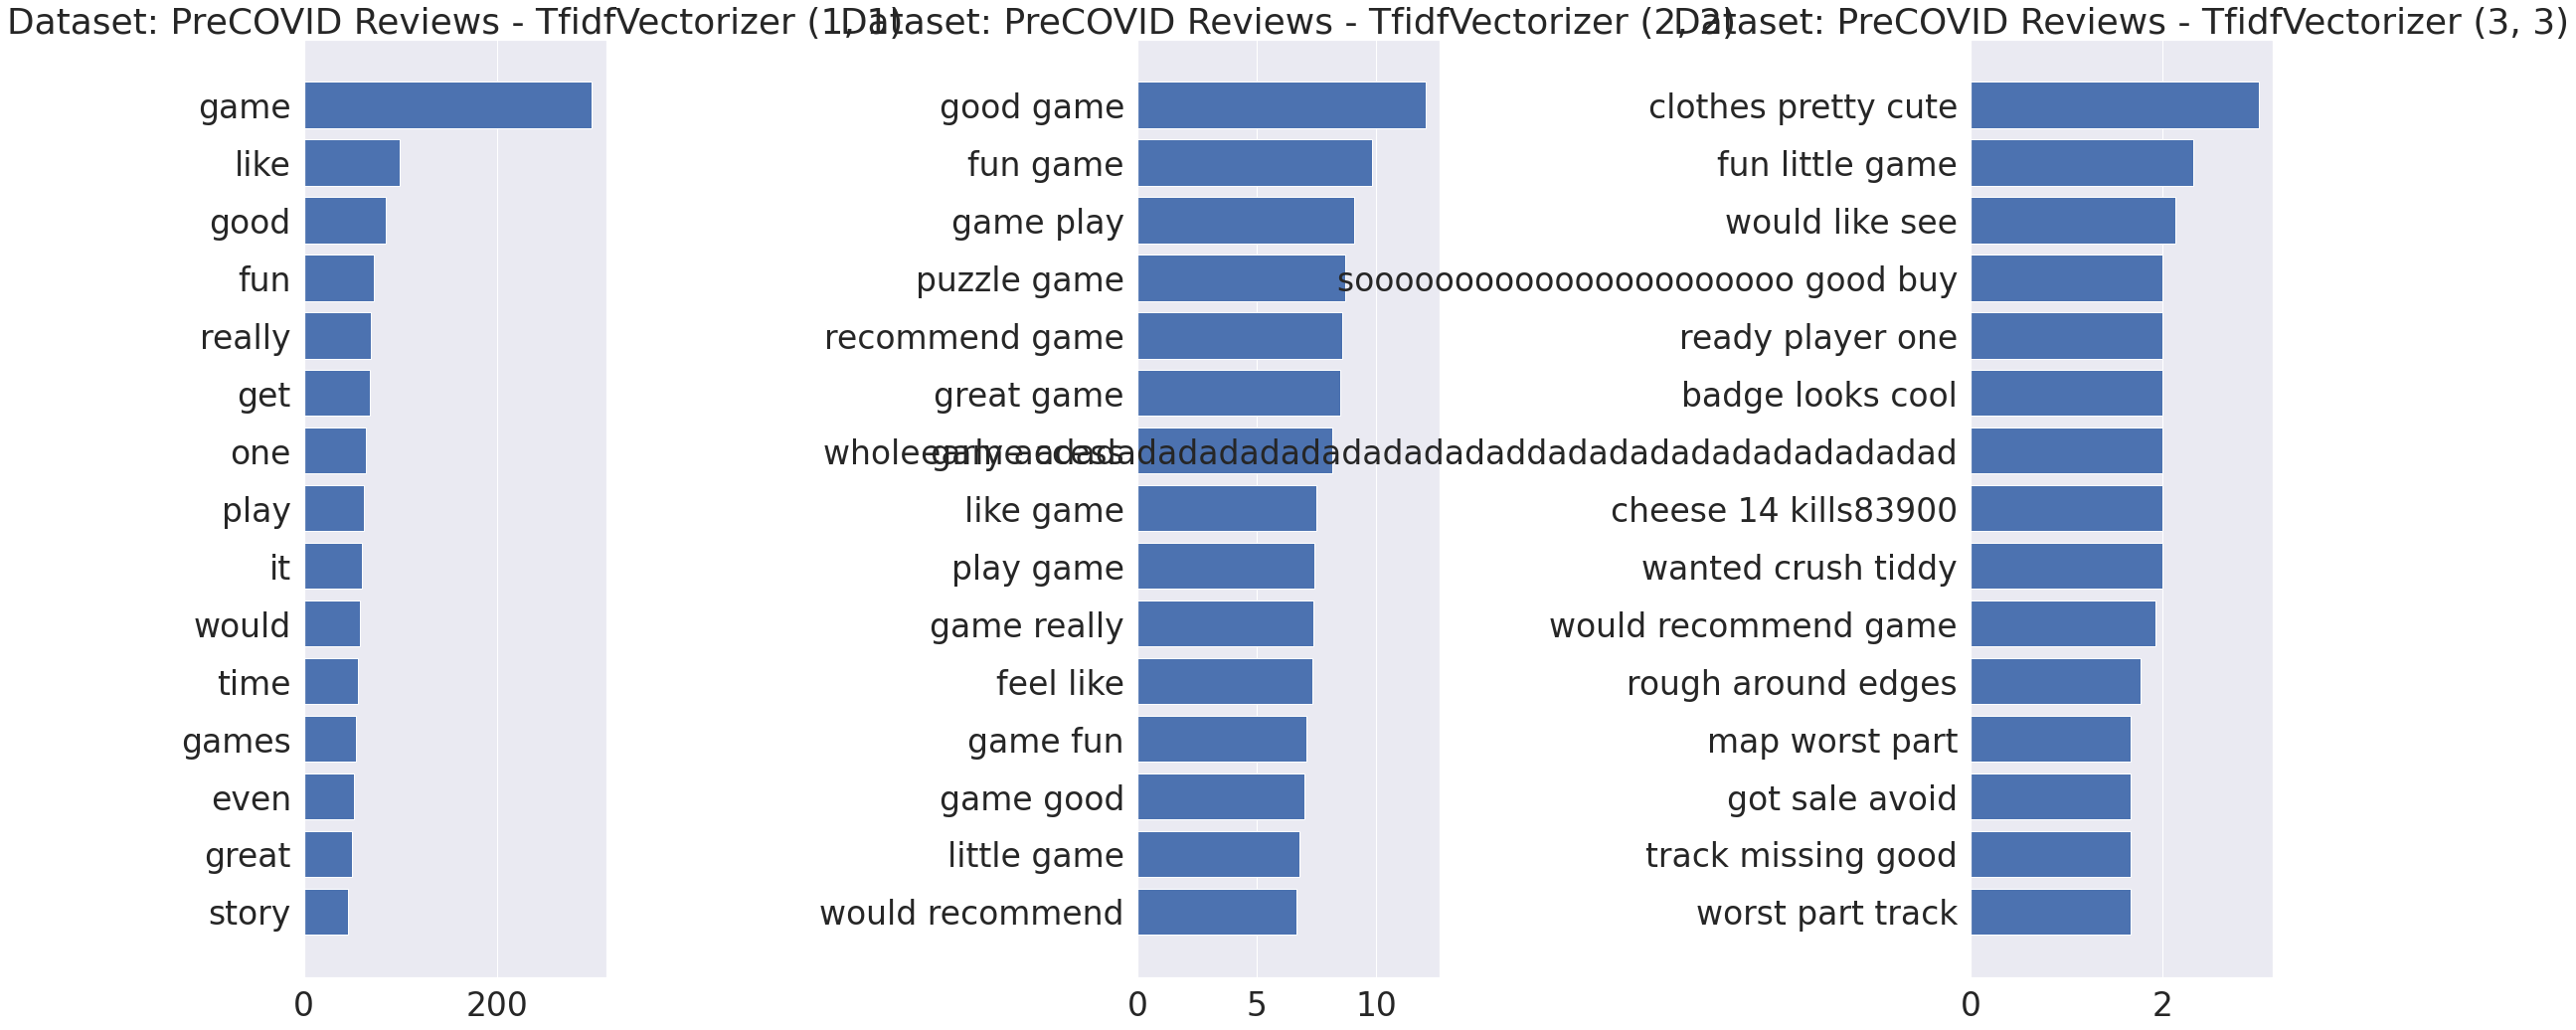

In [68]:
countplots(preCOVID[preCOVID["Top Reviews by Upvotes.1"].isnull() ==False]["Top Reviews by Upvotes.1"],"PreCOVID Reviews",[TfidfVectorizer],cols=3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27627 missing from current font.
  """Draw mathtext using :mod:`matplotlib.mathtext`."""
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26080 missing from current font.
  """Draw mathtext using :mod:`matplotlib.mathtext`."""
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36136 missing from current font.
  """Draw mathtext using :mod:`matplotlib.mathtext`."""
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 37327 missing from current font.
  """Draw mat

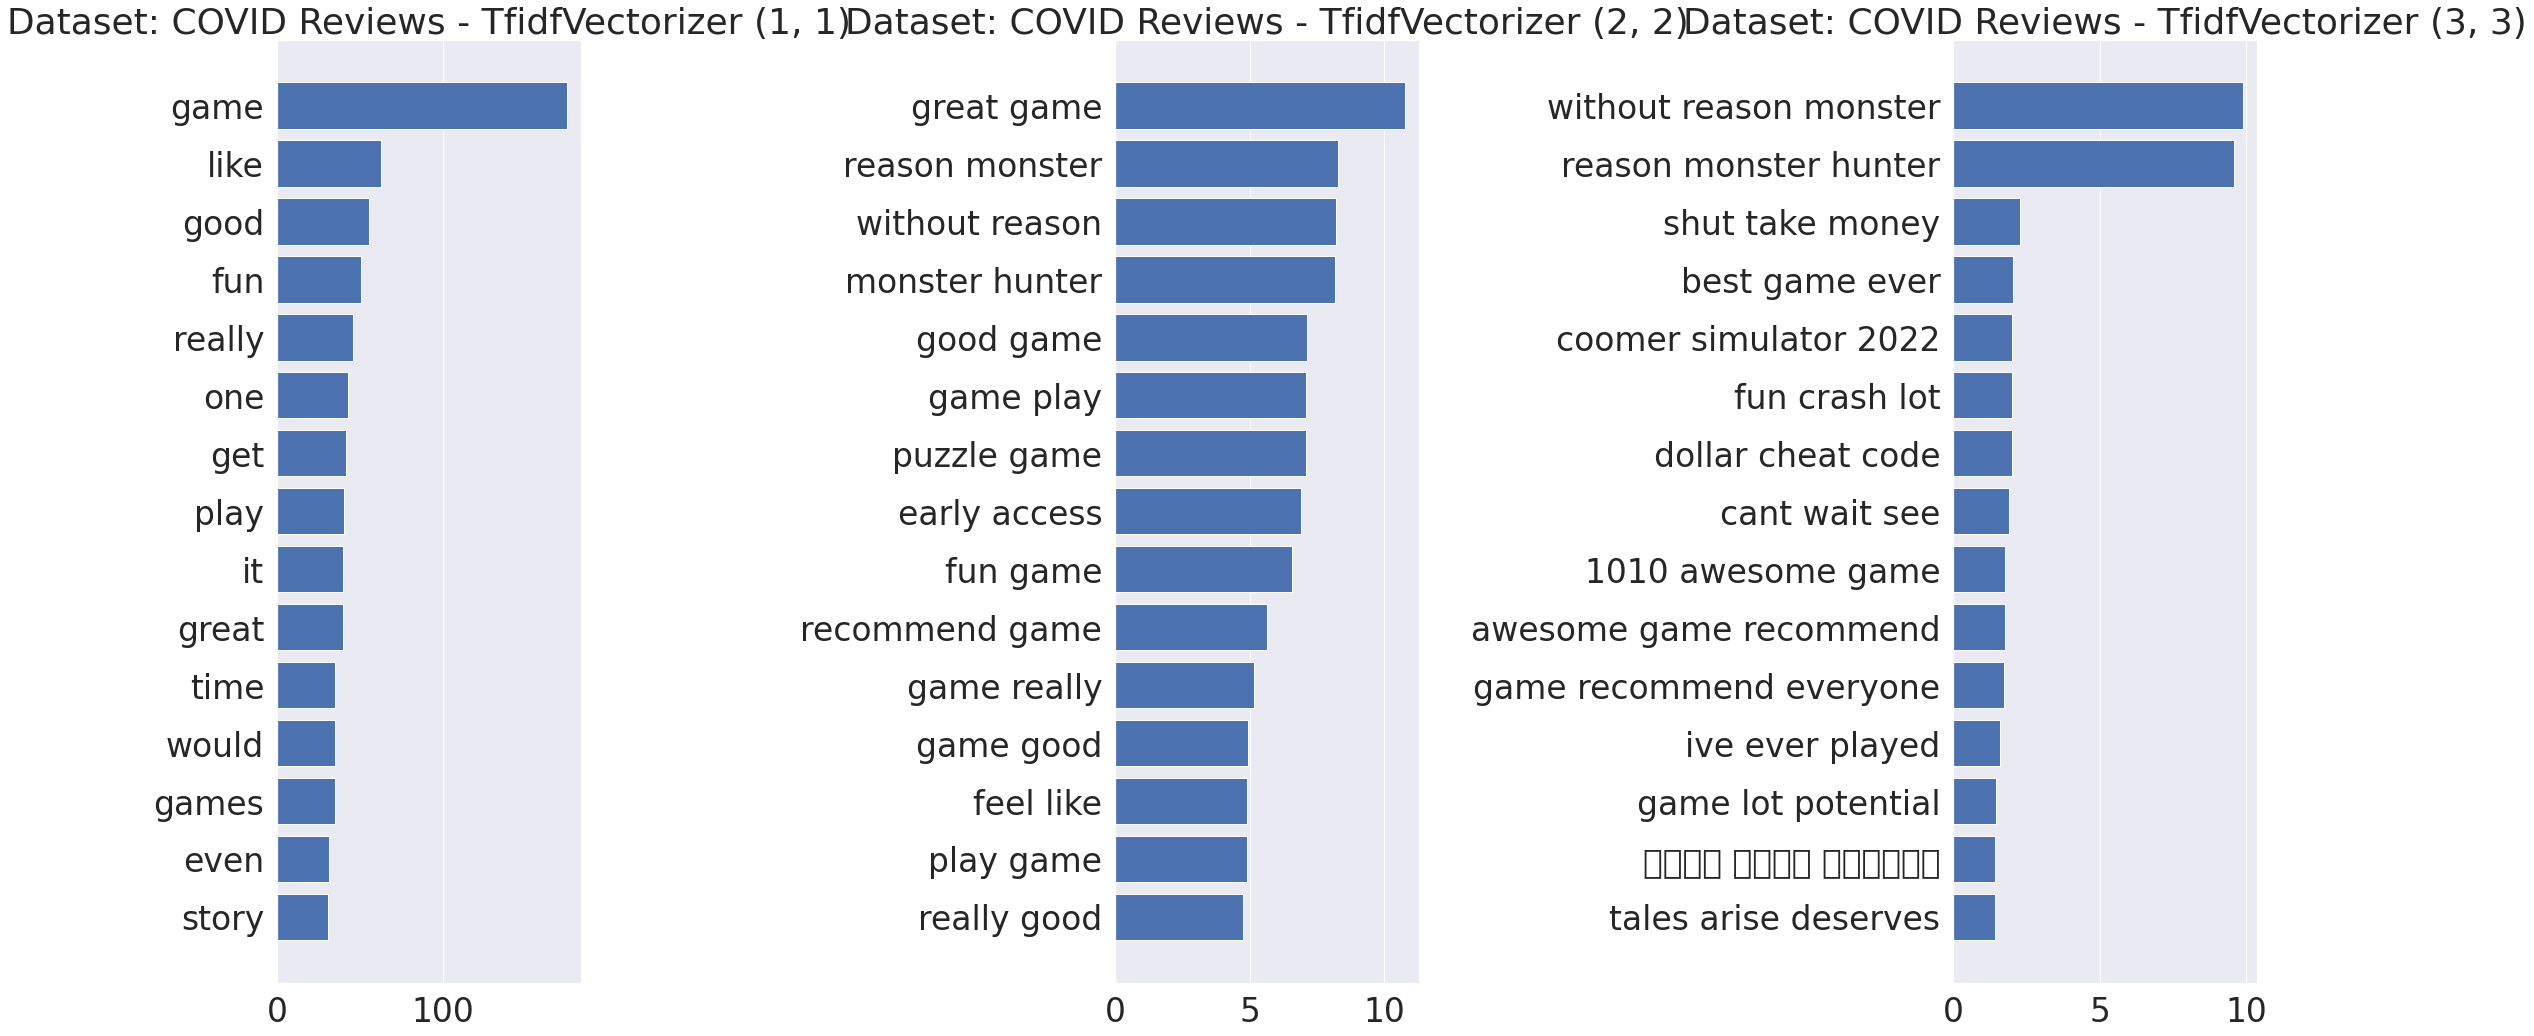

In [69]:
countplots(COVID[COVID["Top Reviews by Upvotes.1"].isnull() ==False]["Top Reviews by Upvotes.1"],"COVID Reviews",[TfidfVectorizer],cols=3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


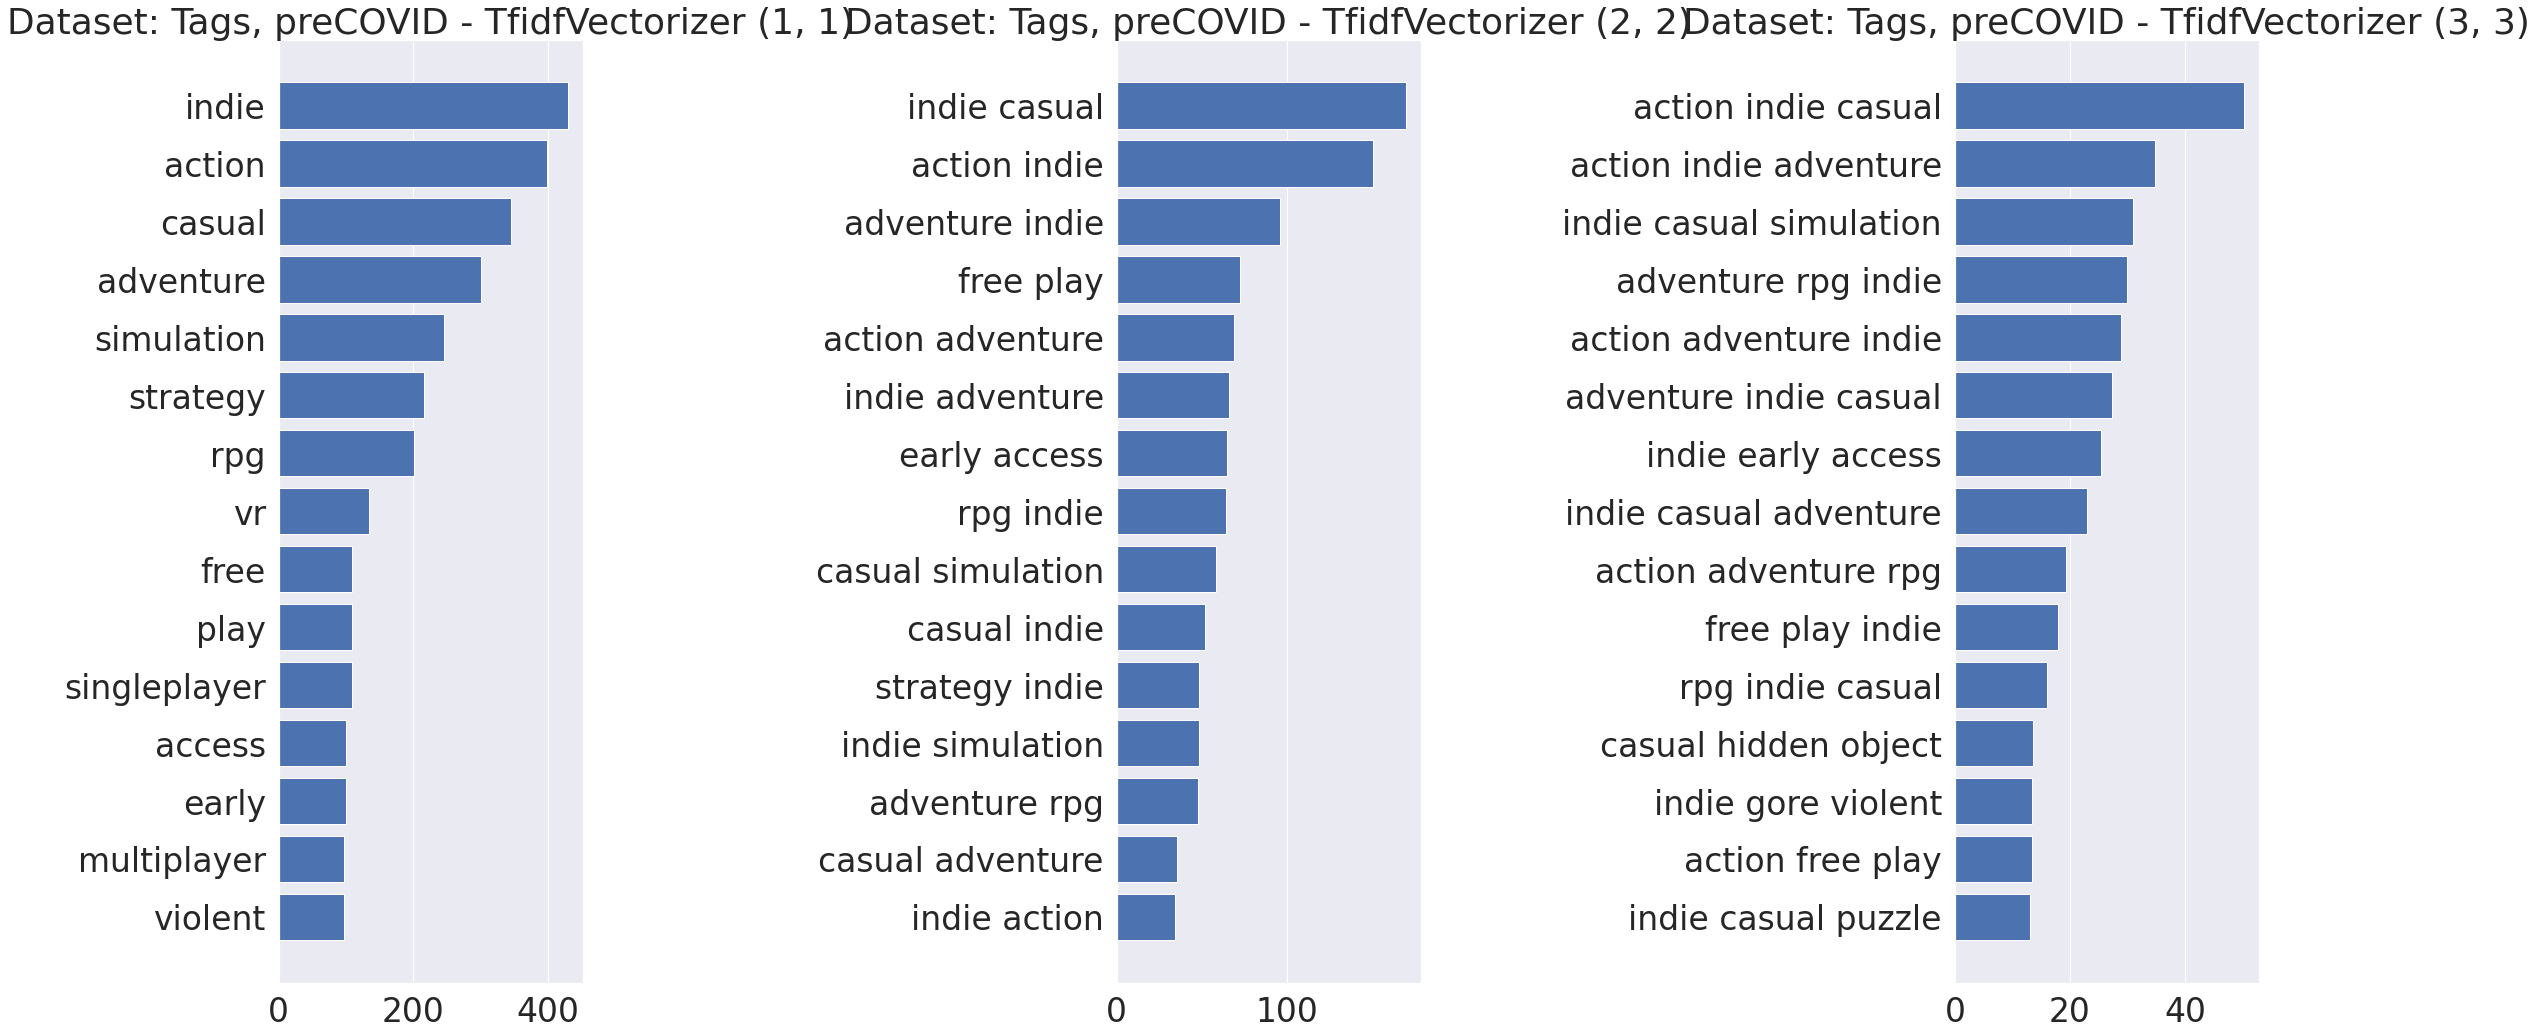

In [70]:
countplots(preCOVID[preCOVID["tags.1"].isnull() ==False]['tags.1'],"Tags, preCOVID",[TfidfVectorizer],cols=3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


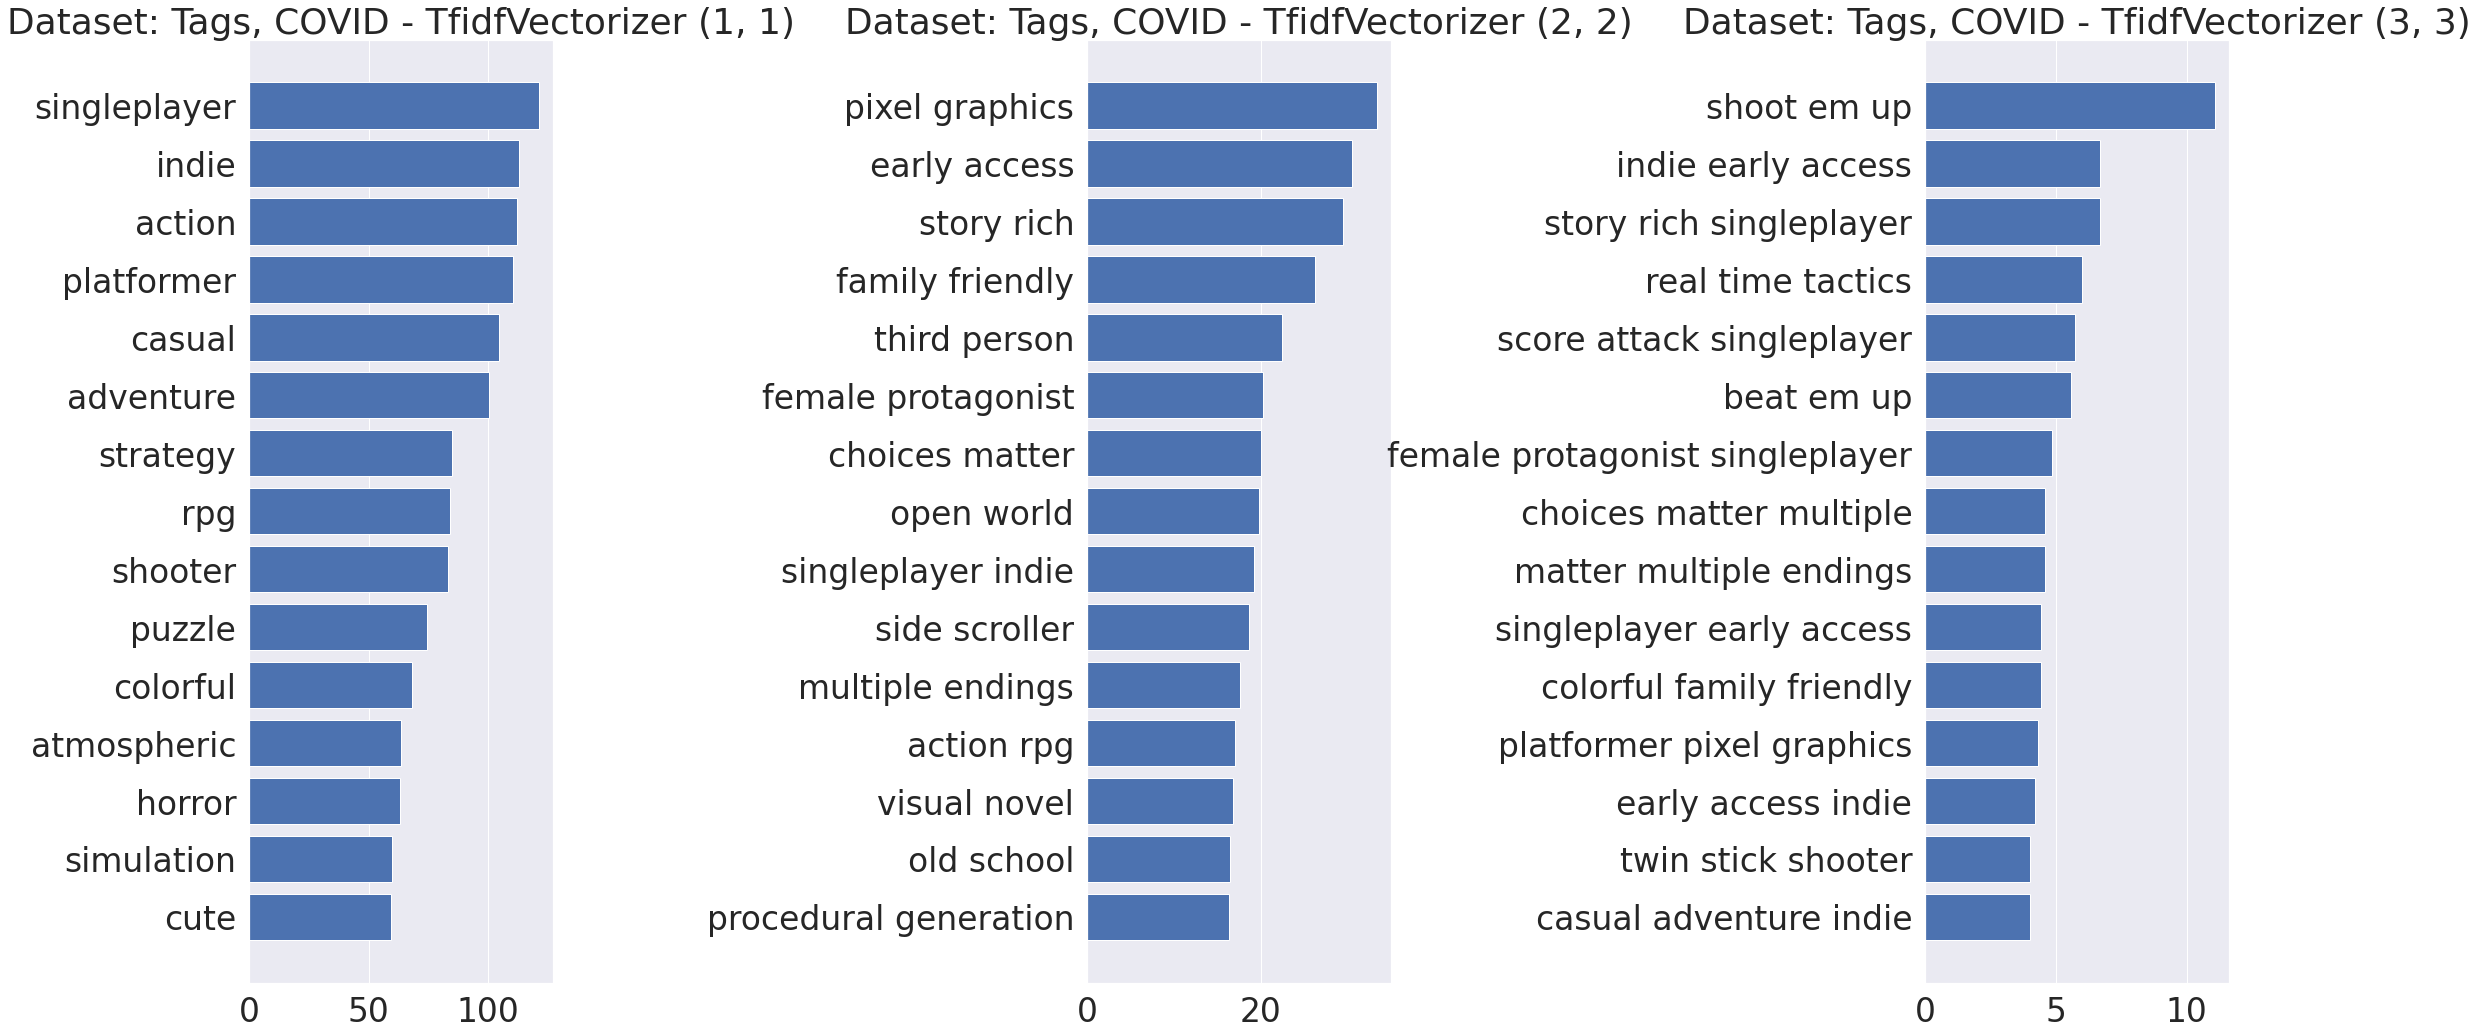

In [71]:
countplots(COVID[COVID["tags.1"].isnull() ==False]['tags.1'],"Tags, COVID",[TfidfVectorizer],cols=3)

In [72]:
Columns = ["detailed_description.1","Top Reviews by Upvotes.1", "tags.1"]
Keywords = getSpacyKeywords(preCOVID, Columns)
Keywords

detailed_description.1 [('good luck marinefeatures old school shooter action autoheal', 0.020208843237046643), ('activatable items', 0.016462855303656564), ('combat themresources', 0.014088077378533488), ('naked girls', 0.013996759220196234), ('realtimecustom soundtrack', 0.012963302116508701), ('neutral care application', 0.007353487523019592), ('career vigilante', 0.006308101355913257), (' valerie cosplayed by「星之迟迟」  holborn cosplayed by「沧霁桔梗」  annemarie', 0.002103447297393025), ('backpack', 0.001992734850406646), ('142x142', 0.0)]
Top Reviews by Upvotes.1 [('dlcawesome game', 0.09183788277804608), ('really excellent coaching strategy simulation endeavour game', 0.048785555081945806), ('bit three initial characters', 0.018179773947004606), ('better imho crescendo', 0.0175846704018858), ('middle instead old working side pieces', 0.015138279848453867), ('stuff', 0.013602202999663787), ('appealing looks', 0.010715780441080413), ('400 cars', 0.0047458569301807646), ('kind thank youone ad

,detailed_description.1,Top Reviews by Upvotes.1,tags.1
0,(good luck marinefeatures old school shooter a...,"(dlcawesome game, 0.09183788277804608)","(indie strategy rpg, 0.06239875862525076)"
1,"(activatable items, 0.016462855303656564)",(really excellent coaching strategy simulation...,"(casual, 0.05218466496054418)"
2,"(combat themresources, 0.014088077378533488)","(bit three initial characters, 0.0181797739470...",(partybased rpg casual simulation strategy r...
3,"(naked girls, 0.013996759220196234)","(better imho crescendo, 0.0175846704018858)","(horror, 0.04960599687028332)"
4,"(realtimecustom soundtrack, 0.012963302116508701)","(middle instead old working side pieces, 0.015...","(casual strategy simulation, 0.0420041231441..."
5,"(neutral care application, 0.007353487523019592)","(stuff, 0.013602202999663787)",( vr adventure nudity visual novel anime ca...
6,"(career vigilante, 0.006308101355913257)","(appealing looks, 0.010715780441080413)",( shooter survival casual hidden object adv...
7,( valerie cosplayed by「星之迟迟」 holborn cosplaye...,"(400 cars, 0.0047458569301807646)",( linear singleplayer short actionadventure...
8,"(backpack, 0.001992734850406646)","(kind thank youone advanced locos, 0.004483864...","(wargame beautiful firstperson, 0.0146459882..."
9,"(142x142, 0.0)","(blender, 0.001726524309163677)","(indie lgbtq, 0.0048312147261521535)"


In [73]:
Columns = ["detailed_description.1","Top Reviews by Upvotes.1", "tags.1"]
Keywords = getSpacyKeywords(COVID, Columns)
Keywords

detailed_description.1 [('fierce battles', 0.02220538803965952), (' retro soundtrackwe’re mad herewelcome world strange fairy taleswe', 0.016311727326121878), ('historically accurate orders battle', 0.014104531801675278), ('dozens hours', 0.013035113478391036), ('old concept humorism', 0.012766916244914803), ('five authentic special 50th anniversary liveries', 0.009598672521851922), ('camisolethe hour witch chapter', 0.00824967289992725), ('farmer harvest crops', 0.006683710474763377), ('sharlotte holmes rising notoriety', 0.006093406053539578), ('interiors', 0.0020927050565569703)]
Top Reviews by Upvotes.1 [('world great game', 0.0889889627872201), ('solid foundation good game', 0.085285756105622), ('good view', 0.04018296234134873), ('great graphics effects', 0.03193543189337958), ('recommended gpu memory requirements', 0.021647172972688478), ('crazy 3d', 0.008439889982820671), ('holes wall', 0.006345567929091307), ('novas mecânicas', 0.0047265974022142635), ('these feeding', 0.00065

,detailed_description.1,Top Reviews by Upvotes.1,tags.1
0,"(fierce battles, 0.02220538803965952)","(world great game, 0.0889889627872201)","(rich coop multiplayer, 0.025623837124014608)"
1,( retro soundtrackwe’re mad herewelcome world ...,"(solid foundation good game, 0.085285756105622)","(female protagonist loot, 0.025291227629061518)"
2,"(historically accurate orders battle, 0.014104...","(good view, 0.04018296234134873)","( gridbased movement adventure logic, 0.0252..."
3,"(dozens hours, 0.013035113478391036)","(great graphics effects, 0.03193543189337958)","( open world, 0.024522972653921563)"
4,"(old concept humorism, 0.012766916244914803)","(recommended gpu memory requirements, 0.021647...","(puzzle jrpg anime, 0.02336909476812856)"
5,(five authentic special 50th anniversary liver...,"(crazy 3d, 0.008439889982820671)","(dungeon crawler rpg, 0.02161972464128653)"
6,"(camisolethe hour witch chapter, 0.00824967289...","(holes wall, 0.006345567929091307)","( sports arcade, 0.018495964938301284)"
7,"(farmer harvest crops, 0.006683710474763377)","(novas mecânicas, 0.0047265974022142635)","( cartoon cartoony, 0.013006522755322603)"
8,"(sharlotte holmes rising notoriety, 0.00609340...","(these feeding, 0.0006565542312748728)","(dinosaurs, 0.009987429909014904)"
9,"(interiors, 0.0020927050565569703)","(four, 0.0)","(bowling, 0.008662540444638695)"


In [88]:
Keywords = getYakeKeywords(preCOVID, Columns)
Keywords

detailed_description.1 [('fantasy grounds full', 4.719075958133762e-06), ('time purchase fantasy', 6.099164674919211e-06), ('designed fantasy grounds', 7.008825167309043e-06), ('time fantasy grounds', 7.727708480341838e-06), ('grounds full ultimate', 8.78637391440827e-06), ('world', 1.0519382149766266e-05), ('time', 1.120302574502556e-05), ('fantasy grounds features', 1.4549375673713531e-05), ('object puzzle adventure', 1.4619788941382635e-05), ('purchase fantasy grounds', 1.5070501992461628e-05)]
Top Reviews by Upvotes.1 [('good', 2.4908690478800077e-06), ('time', 2.7938676240155917e-06), ('pretty good', 3.565443279610114e-06), ('fun', 4.036455101376438e-06), ('good good bad', 4.728367701083909e-06), ('lot fun', 5.23441712822182e-06), ('good time', 5.317920679367592e-06), ('great', 6.602163739273265e-06), ('make', 7.0496351521536355e-06), ('level good time', 7.353078043864978e-06)]
tags.1 [('action indie casual', 2.6245355879204356e-08), ('action indie adventure', 4.384211911494747e-0

,detailed_description.1,Top Reviews by Upvotes.1,tags.1
0,"(fantasy grounds full, 4.719075958133762e-06)","(good, 2.4908690478800077e-06)","(action indie casual, 2.6245355879204356e-08)"
1,"(time purchase fantasy, 6.099164674919211e-06)","(time, 2.7938676240155917e-06)","(action indie adventure, 4.384211911494747e-08)"
2,"(designed fantasy grounds, 7.008825167309043e-06)","(pretty good, 3.565443279610114e-06)","(action adventure indie, 4.6611095059049426e-08)"
3,"(time fantasy grounds, 7.727708480341838e-06)","(fun, 4.036455101376438e-06)","(adventure indie casual, 4.867447357178507e-08)"
4,"(grounds full ultimate, 8.78637391440827e-06)","(good good bad, 4.728367701083909e-06)","(indie casual simulation, 5.536916968082234e-08)"
5,"(world, 1.0519382149766266e-05)","(lot fun, 5.23441712822182e-06)","(indie action indie, 6.318201009564217e-08)"
6,"(time, 1.120302574502556e-05)","(good time, 5.317920679367592e-06)","(indie casual adventure, 6.692740116120448e-08)"
7,"(fantasy grounds features, 1.4549375673713531e...","(great, 6.602163739273265e-06)","(indie casual action, 6.998761567787828e-08)"
8,"(object puzzle adventure, 1.4619788941382635e-05)","(make, 7.0496351521536355e-06)","(indie action adventure, 8.51548852040326e-08)"
9,"(purchase fantasy grounds, 1.5070501992461628e...","(level good time, 7.353078043864978e-06)","(casual action indie, 9.066577485543324e-08)"


In [89]:
Keywords = getYakeKeywords(COVID, Columns)
Keywords

detailed_description.1 [('include map pack', 1.282427681198531e-06), ('dlc include map', 1.3705033451516865e-06), ('feature dlc include', 3.6179630694036282e-06), ('enemy lines break', 4.341422609520506e-06), ('lines break enemy', 4.341422609520506e-06), ('control tanksthrough enemy', 5.471582957032461e-06), ('enemy tanks feature', 5.6353475275182344e-06), ('control tanks enemy', 6.705176917214008e-06), ('number enemies shooting', 8.177507513535571e-06), ('include mission pack', 8.43102635949848e-06)]
Top Reviews by Upvotes.1 [('monika monika monika', 1.6962666930546023e-07), ('real isnt real', 2.182889512692868e-07), ('isnt real isnt', 2.6314007311896785e-07), ('monika monika', 2.196599201267268e-06), ('isnt real', 2.908731356261054e-06), ('real isnt', 2.9138343937281786e-06), ('good good bad', 7.480162460175851e-06), ('good', 8.022513474284485e-06), ('time', 8.434355164697334e-06), ('fun', 1.1388467181506946e-05)]
tags.1 [('singleer action adventure', 2.805646579600524e-07), ('single

,detailed_description.1,Top Reviews by Upvotes.1,tags.1
0,"(include map pack, 1.282427681198531e-06)","(monika monika monika, 1.6962666930546023e-07)","(singleer action adventure, 2.805646579600524e..."
1,"(dlc include map, 1.3705033451516865e-06)","(real isnt real, 2.182889512692868e-07)","(singleer indie action, 2.811070913952723e-07)"
2,"(feature dlc include, 3.6179630694036282e-06)","(isnt real isnt, 2.6314007311896785e-07)","(singleer indie casual, 2.8750139684404036e-07)"
3,"(enemy lines break, 4.341422609520506e-06)","(monika monika, 2.196599201267268e-06)","(story rich singleer, 3.104886725633519e-07)"
4,"(lines break enemy, 4.341422609520506e-06)","(isnt real, 2.908731356261054e-06)","(singleer early access, 3.292370067411761e-07)"
5,"(control tanksthrough enemy, 5.471582957032461...","(real isnt, 2.9138343937281786e-06)","(singleer indie adventure, 3.2953302546543304e..."
6,"(enemy tanks feature, 5.6353475275182344e-06)","(good good bad, 7.480162460175851e-06)","(singleer casual adventure, 3.303338864313928e..."
7,"(control tanks enemy, 6.705176917214008e-06)","(good, 8.022513474284485e-06)","(singleer adventure casual, 3.684493348657843e..."
8,"(number enemies shooting, 8.177507513535571e-06)","(time, 8.434355164697334e-06)","(indie singleer casual, 4.025019555816564e-07)"
9,"(include mission pack, 8.43102635949848e-06)","(fun, 1.1388467181506946e-05)","(singleer action casual, 4.0859227959833596e-07)"
